In [1]:
!git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5 (delta 2), reused 5 (delta 2), pack-reused 0
Unpacking objects: 100% (5/5), 480 bytes | 14.00 KiB/s, done.
From https://github.com/nikitakuklev/APSopt-workspaces
   0545975..0026f25  master     -> origin/master
Updating 0545975..0026f25
Fast-forward
 nsls-ii/scripts/gen3_shared.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)


In [2]:
import sys
import logging
import json
import numpy as np
import pandas as pd
from datetime import datetime
import time

from apsopt.core.optimizer import Optimizer, get_generator_class
from apsopt.core.evaluators import FunctionEvaluator
from apsopt.util.pydantic.options import AlgorithmOptions
from apsopt.util.pydantic.vocs import GVOCS
import sext_tools as st
from gen3_shared import prepare, get_eval_f, compute_family_k2l_from_knob_k2l, get_raw_eval_f

logger = logging.getLogger(__name__)

### SETUP

In [3]:
MODE = 'DW_SH1N_SH3N_SH4N_SL1_SL2_SL3_SH1DW081828_SH3DW081828_SH4DW081828'
NAME_ROOT = f'mobo_{MODE}_v1'

from apsopt.util.log import prepare_loggers
prepare_loggers()
fh = logging.FileHandler(f'logs/{NAME_ROOT}_{datetime.now():%Y%m%dT%H%M%S}.optlog', mode='w')
fh.setLevel(logging.NOTSET)
logging.getLogger().addHandler(fh)

dfknobs, ivals_ref, ivals, gvocs, iknobvals = prepare(MODE)
variables = gvocs.variables

reference_point = {'LT': 3.0, # hours
                   'EFF': 10.0 # % injected
                   }

display(pd.DataFrame(ivals_ref,index=[0]))
display(pd.DataFrame(variables))

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,3.966582,-1.171022,-3.16418,-2.654321,7.135584,-5.892172,3.966582,3.966582,3.966582,-1.171022,-1.171022,-1.171022,-3.16418,-3.16418,-3.16418


,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,SH3-DW18,SH3-DW28,SH4-DW08,SH4-DW18,SH4-DW28
0,-0.47599,-0.140523,-0.379702,-0.318519,-0.85627,-0.707061,-0.47599,-0.47599,-0.47599,-0.140523,-0.140523,-0.140523,-0.379702,-0.379702,-0.379702
1,0.47599,0.140523,0.379702,0.318519,0.85627,0.707061,0.47599,0.47599,0.47599,0.140523,0.140523,0.140523,0.379702,0.379702,0.379702


In [4]:
#TEST_MODE = True
TEST_MODE = False

In [5]:
inputs_dict = compute_family_k2l_from_knob_k2l(
    dfknobs, {k:variables[k][0] for k in variables.keys()}, ivals, True)
inputs_dict

SH1N   : +3.967 + -0.476 -> +3.491
SH3N   : -1.171 + -0.141 -> -1.312
SH4N   : -3.164 + -0.380 -> -3.544
SL1    : -2.654 + -0.319 -> -2.973
SL2    : +7.136 + -0.856 -> +6.279
SL3    : -5.892 + -0.707 -> -6.599
SH1-DW08: +3.967 + -0.476 -> +3.491
SH1-DW18: +3.967 + -0.476 -> +3.491
SH1-DW28: +3.967 + -0.476 -> +3.491
SH3-DW08: -1.171 + -0.141 -> -1.312
SH3-DW18: -1.171 + -0.141 -> -1.312
SH3-DW28: -1.171 + -0.141 -> -1.312
SH4-DW08: -3.164 + -0.380 -> -3.544
SH4-DW18: -3.164 + -0.380 -> -3.544
SH4-DW28: -3.164 + -0.380 -> -3.544


{'SH1N': 3.4905925296,
 'SH3N': -1.31154428384,
 'SH4N': -3.54388175904,
 'SL1': -2.9728397552000003,
 'SL2': 6.279314175200001,
 'SL3': -6.599232776640001,
 'SH1-DW08': 3.4905925296,
 'SH1-DW18': 3.4905925296,
 'SH1-DW28': 3.4905925296,
 'SH3-DW08': -1.31154428384,
 'SH3-DW18': -1.31154428384,
 'SH3-DW28': -1.31154428384,
 'SH4-DW08': -3.54388175904,
 'SH4-DW18': -3.54388175904,
 'SH4-DW28': -3.54388175904}

### Test eval function

In [6]:
# Test
if False and not TEST_MODE:
    raw_eval_f = get_raw_eval_f()
    raw_eval_f(inputs_dict, meas_bxb_tunes=True, meas_lifetime=True, meas_inj_eff=True)

In [7]:
eval_f = get_eval_f(TEST_MODE, gvocs, dfknobs, ivals)
ev = FunctionEvaluator(script=eval_f)

generator_name = 'aps_mobo'
gc = get_generator_class(generator_name)
gen = gc(gvocs=gvocs)
gen.numerical_optimizer.n_raw_samples = 128 #512
gen.numerical_optimizer.n_restarts = 20
gen.gp_constructor.use_low_noise_prior = False
gen.gp_constructor.use_high_noise_prior = False
gen.max_travel_distances = [1.0] * len(gvocs.variables_active)
gen.reference_point = reference_point

[DEBUG][20:43:24.787 __init__.p   47] Creating converter from 7 to 5
[DEBUG][20:43:24.789 __init__.p   47] Creating converter from 5 to 7
[DEBUG][20:43:24.790 __init__.p   47] Creating converter from 7 to 5
[DEBUG][20:43:24.791 __init__.p   47] Creating converter from 5 to 7
[INFO ][20:43:24.896 generator.   16] Initializing generator aps_mobo
[INFO ][20:43:24.898 generator.   64] Initialized generator aps_mobo


In [8]:
options = AlgorithmOptions(store_history=True, dump_every_step=True)
opt = Optimizer(options=options, generator=gen, evaluator=ev, gvocs=gvocs)

[DEBUG][20:43:24.910 optimizer.   83] Initializing optimizer with tag='5791d0cdb1' store_history=True dump_every_step=True history_directory=None execution_mode='sync'
[DEBUG][20:43:24.912 optimizer.  138] Generator set to: supports_batch_generation=True supports_multi_objective=True vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.3797016170

### Sample at initial values

In [9]:
opt.generate_at(iknobvals)
opt.evaluate_data()

[INFO ][20:43:24.946 optimizer.  573] Evaluating 1 inputs
[DEBUG][20:43:24.948 evaluators  193] Data kwargs: row={'SH1N': -0.08, 'SH3N': -0.04, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': -0.15, 'SL3': -0.15, 'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.02, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.02, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][20:43:24.979 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8865824200000003, 'SH3N': -1.211021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 6.98558429, 'SL3': -6.042172122000001, 'SH1-DW08': 3.9865824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.1510216819999999, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.144180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.022; RMS(dx, dy) [m] = (7.930e-07, 1.231e-06)
Orbit correction converged


[INFO ][20:43:30.388 opt_funcs.  734] Lifetime measurement START
[INFO ][20:43:38.780 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.605 (raw tau [hr] = 6.573, epsy [pm] = 13.64) (took 8.4 [s])
Inj. Eff. = 19.60 (took 17.4 [s])
Eval. func. finished.


[DEBUG][20:43:56.155 evaluators  211] Result: output={'result': {'_nux': 0.21673450849428705, '_nuy': 0.26952959231075896, '_eps_x_bxbOn': 1.0192968842876669e-09, '_eps_y_bxbOn': 1.3689403755795526e-11, '_eps_x_bxbOff': 1.0197805178043496e-09, '_eps_y_bxbOff': 1.364070438959905e-11, 'LT': 6.60527879150579, '_raw_LT': 6.5725287524812535, 'EFF': 19.60329232565315}, 'exception': None, 'traceback': '', 'wall_time': 31.204600736498833, 'cpu_time': 14.400182532}
[DEBUG][20:43:56.161 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:43:56.179 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00000.json] in [0.01156]s


In [10]:
assert opt.data.iloc[0].valid, f'ERROR: {opt.data.iloc[0].traceback}'
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.08,-0.04,0.0,0.0,-0.15,-0.15,0.02,0.0,0.0,0.02,...,True,0.216735,0.26953,1.019297e-09,1.368940e-11,1.019781e-09,1.364070e-11,6.605279,6.572529,19.603292


### Sample close to initial point

In [11]:
mt = {k: 0.05 for k in variables.keys()}
opt.generate_random_around_point(n=2, point=iknobvals, spans=mt, use_normalized_distances=True)
opt.evaluate_data()

[INFO ][20:44:11.220 optimizer.  573] Evaluating 2 inputs
[DEBUG][20:44:11.222 evaluators  193] Data kwargs: row={'SH1-DW08': 0.019328335667735664, 'SH1-DW18': 0.008324564378163184, 'SH1-DW28': -0.009055922184052727, 'SH1N': -0.09375213809566328, 'SH3-DW08': 0.013636464435537258, 'SH3-DW18': 0.00592543806789096, 'SH3-DW28': -0.0028158955733294565, 'SH3N': -0.044160679989815176, 'SH4-DW08': 0.034898060465383726, 'SH4-DW18': -0.011939375745861763, 'SH4-DW28': -0.014691812218357893, 'SH4N': -0.00585875023115112, 'SL1': -0.0085003438233523, 'SL2': -0.1365788300453699, 'SL3': -0.17018189055188684}
[INFO ][20:44:11.227 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.872830281904337, 'SH3N': -1.215182361989815, 'SH4N': -3.170038892231151, 'SL1': -2.6628215538233526, 'SL2': 6.99900545995463, 'SL3': -6.0623540125518875, 'SH1-DW08': 3.985910755667736, 'SH1-DW18': 3.9749069843781637, 'SH1-DW28': 3.9575264978159477, 'SH3-DW08': -1.1573852175644626, 'SH3-DW18': -1.1650962439321089, 'SH3-DW28': -1

SH1N   : +3.967 + -0.094 -> +3.873
SH3N   : -1.171 + -0.044 -> -1.215
SH4N   : -3.164 + -0.006 -> -3.170
SL1    : -2.654 + -0.009 -> -2.663
SL2    : +7.136 + -0.137 -> +6.999
SL3    : -5.892 + -0.170 -> -6.062
SH1-DW08: +3.967 + +0.019 -> +3.986
SH1-DW18: +3.967 + +0.008 -> +3.975
SH1-DW28: +3.967 + -0.009 -> +3.958
SH3-DW08: -1.171 + +0.014 -> -1.157
SH3-DW18: -1.171 + +0.006 -> -1.165
SH3-DW28: -1.171 + -0.003 -> -1.174
SH4-DW08: -3.164 + +0.035 -> -3.129
SH4-DW18: -3.164 + -0.012 -> -3.176
SH4-DW28: -3.164 + -0.015 -> -3.179
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.006; RMS(dx, dy) [m] = (9.744e-07, 1.261e-06)
Orbit correction converged


[INFO ][20:44:15.311 opt_funcs.  734] Lifetime measurement START
[INFO ][20:44:20.821 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 6.547 (raw tau [hr] = 6.490, epsy [pm] = 13.50) (took 5.5 [s])
Inj. Eff. = 15.87 (took 18.1 [s])
Eval. func. finished.


[DEBUG][20:44:38.943 evaluators  211] Result: output={'result': {'_nux': 0.216185190893408, '_nuy': 0.2689192371815182, '_eps_x_bxbOn': 1.0165117428925e-09, '_eps_y_bxbOn': 1.360333947095836e-11, '_eps_x_bxbOff': 1.0212244402660439e-09, '_eps_y_bxbOff': 1.3496133758091613e-11, 'LT': 6.5472673940862505, '_raw_LT': 6.490168224911452, 'EFF': 15.867713816171152}, 'exception': None, 'traceback': '', 'wall_time': 27.719688817858696, 'cpu_time': 10.452718990999998}
[DEBUG][20:44:38.944 evaluators  193] Data kwargs: row={'SH1-DW08': 0.029270908190599645, 'SH1-DW18': -0.020817525268264504, 'SH1-DW28': 0.017231516120990168, 'SH1N': -0.07879284628520747, 'SH3-DW08': 0.020193102685887046, 'SH3-DW18': -0.0022179509549194766, 'SH3-DW28': 0.005813790057284128, 'SH3N': -0.038338434475722945, 'SH4-DW08': 0.0064293829171238265, 'SH4-DW18': 0.013216165177484841, 'SH4-DW28': 0.005530572173848353, 'SH4N': 0.007994410146966693, 'SL1': 0.012937696994632205, 'SL2': -0.18402858423845722, 'SL3': -0.122722926833

SH1N   : +3.967 + -0.079 -> +3.888
SH3N   : -1.171 + -0.038 -> -1.209
SH4N   : -3.164 + +0.008 -> -3.156
SL1    : -2.654 + +0.013 -> -2.641
SL2    : +7.136 + -0.184 -> +6.952
SL3    : -5.892 + -0.123 -> -6.015
SH1-DW08: +3.967 + +0.029 -> +3.996
SH1-DW18: +3.967 + -0.021 -> +3.946
SH1-DW28: +3.967 + +0.017 -> +3.984
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.002 -> -1.173
SH3-DW28: -1.171 + +0.006 -> -1.165
SH4-DW08: -3.164 + +0.006 -> -3.158
SH4-DW18: -3.164 + +0.013 -> -3.151
SH4-DW28: -3.164 + +0.006 -> -3.159
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.024; RMS(dx, dy) [m] = (1.290e-06, 1.256e-06)
Orbit correction converged


[INFO ][20:44:43.039 opt_funcs.  734] Lifetime measurement START
[INFO ][20:44:53.097 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 6.666 (raw tau [hr] = 6.656, epsy [pm] = 13.67) (took 10.1 [s])
Inj. Eff. = 24.82 (took 16.4 [s])
Eval. func. finished.


[DEBUG][20:45:09.511 evaluators  211] Result: output={'result': {'_nux': 0.21658191971197688, '_nuy': 0.2688582097303446, '_eps_x_bxbOn': 1.020342213474144e-09, '_eps_y_bxbOn': 1.3859400624539446e-11, '_eps_x_bxbOff': 1.0186315738410065e-09, '_eps_y_bxbOff': 1.3673857208693256e-11, 'LT': 6.666144790805011, '_raw_LT': 6.656249090684431, 'EFF': 24.82035741460258}, 'exception': None, 'traceback': '', 'wall_time': 30.565924983471632, 'cpu_time': 15.634193882999995}
[DEBUG][20:45:09.515 optimizer.  291] Adding (2) new data to internal dataframes
[DEBUG][20:45:09.533 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00001.json] in [0.01246]s


In [12]:
opt.data

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.080000,-0.040000,0.000000,0.000000,-0.150000,-0.150000,0.020000,0.000000,0.000000,0.020000,...,True,0.216735,0.269530,1.019297e-09,1.368940e-11,1.019781e-09,1.364070e-11,6.605279,6.572529,19.603292
2,-0.093752,-0.044161,-0.005859,-0.008500,-0.136579,-0.170182,0.019328,0.008325,-0.009056,0.013636,...,True,0.216185,0.268919,1.016512e-09,1.360334e-11,1.021224e-09,1.349613e-11,6.547267,6.490168,15.867714
3,-0.078793,-0.038338,0.007994,0.012938,-0.184029,-0.122723,0.029271,-0.020818,0.017232,0.020193,...,True,0.216582,0.268858,1.020342e-09,1.385940e-11,1.018632e-09,1.367386e-11,6.666145,6.656249,24.820357


### Run optimizer

In [13]:
opt.step()

[DEBUG][20:45:32.944 optimizer.  447] Generating 1 candidates
[DEBUG][20:45:32.953 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.37970161704]}, constraints={}, objectives={'LT': 'MAXIMIZE', 'EFF': 'MAXIMIZE'}, constants={}, observables=[]) with len(data)=3
[INFO ][20:45:33.299    mobo.py  30

SH1N   : +3.967 + -0.058 -> +3.909
SH3N   : -1.171 + -0.028 -> -1.199
SH4N   : -3.164 + +0.038 -> -3.126
SL1    : -2.654 + +0.060 -> -2.594
SL2    : +7.136 + -0.296 -> +6.840
SL3    : -5.892 + -0.021 -> -5.913
SH1-DW08: +3.967 + +0.056 -> +4.022
SH1-DW18: +3.967 + -0.089 -> +3.877
SH1-DW28: +3.967 + +0.077 -> +4.043
SH3-DW08: -1.171 + +0.029 -> -1.142
SH3-DW18: -1.171 + -0.016 -> -1.187
SH3-DW28: -1.171 + +0.026 -> -1.145
SH4-DW08: -3.164 + -0.050 -> -3.215
SH4-DW18: -3.164 + +0.065 -> -3.099
SH4-DW28: -3.164 + +0.040 -> -3.124
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.027; RMS(dx, dy) [m] = (9.600e-07, 1.249e-06)
Orbit correction converged


[INFO ][20:45:41.822 opt_funcs.  734] Lifetime measurement START
[INFO ][20:45:49.957 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 6.786 (raw tau [hr] = 6.905, epsy [pm] = 14.15) (took 8.1 [s])
Inj. Eff. = 76.94 (took 18.6 [s])
Eval. func. finished.


[DEBUG][20:46:08.607 evaluators  211] Result: output={'result': {'_nux': 0.21658191971197688, '_nuy': 0.26788164958530997, '_eps_x_bxbOn': 1.016546629161176e-09, '_eps_y_bxbOn': 1.4322835768495866e-11, '_eps_x_bxbOff': 1.0154392746963512e-09, '_eps_y_bxbOff': 1.4152061347866194e-11, 'LT': 6.7862575392919835, '_raw_LT': 6.904880576154472, 'EFF': 76.94360424535209}, 'exception': None, 'traceback': '', 'wall_time': 31.886737182736397, 'cpu_time': 20.445283303999986}
[DEBUG][20:46:08.610 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][20:46:08.629 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00002.json] in [0.01269]s


In [15]:
for i in range(20):
    print(f'\n** Step #{i+1} at {datetime.now():%Y-%m-%d %H:%M:%S}**\n')
    opt.step()

[DEBUG][21:01:16.007 optimizer.  447] Generating 1 candidates
[DEBUG][21:01:16.014 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL1': [-0.31851854520000006, 0.31851854520000006], 'SL2': [-0.8562701148, 0.8562701148], 'SL3': [-0.70706065464, 0.70706065464], 'SH1-DW08': [-0.4759898904, 0.4759898904], 'SH1-DW18': [-0.4759898904, 0.4759898904], 'SH1-DW28': [-0.4759898904, 0.4759898904], 'SH3-DW08': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW18': [-0.14052260183999998, 0.14052260183999998], 'SH3-DW28': [-0.14052260183999998, 0.14052260183999998], 'SH4-DW08': [-0.37970161704, 0.37970161704], 'SH4-DW18': [-0.37970161704, 0.37970161704], 'SH4-DW28': [-0.37970161704, 0.37970161704]}, constraints={}, objectives={'LT': 'MAXIMIZE', 'EFF': 'MAXIMIZE'}, constants={}, observables=[]) with len(data)=24



** Step #1 at 2023-12-16 21:01:16**



[INFO ][21:01:17.436    mobo.py  301] Mobo called with inputs.size()=torch.Size([24, 15])
[DEBUG][21:01:38.107 bayesian_g  110] Optimize results: tensor([[ 0.1130, -0.1666,  0.0723, -0.0664,  0.0177, -0.0530,  0.0491, -0.0199,
         -0.2110,  0.1877,  0.1334,  0.0945,  0.0771, -0.3168,  0.1635]],
       dtype=torch.float64)
[DEBUG][21:01:38.109 bayesian_g  248] Best candidate from optimize tensor([[ 0.1130, -0.1666,  0.0723, -0.0664,  0.0177, -0.0530,  0.0491, -0.0199,
         -0.2110,  0.1877,  0.1334,  0.0945,  0.0771, -0.3168,  0.1635]],
       dtype=torch.float64)
[DEBUG][21:01:38.112 optimizer.  488] Generated 1 inputs
[INFO ][21:01:38.116 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:01:38.117 evaluators  193] Data kwargs: row={'SH1-DW08': 0.11302622995773948, 'SH1-DW18': -0.1665747662614359, 'SH1-DW28': 0.07229091295554434, 'SH1N': -0.06643906686492264, 'SH3-DW08': 0.017745697097104416, 'SH3-DW18': -0.05296827502778145, 'SH3-DW28': 0.04910666716937375, 'SH3N': -0.019854578

SH1N   : +3.967 + -0.066 -> +3.900
SH3N   : -1.171 + -0.020 -> -1.191
SH4N   : -3.164 + +0.094 -> -3.070
SL1    : -2.654 + +0.077 -> -2.577
SL2    : +7.136 + -0.317 -> +6.819
SL3    : -5.892 + +0.163 -> -5.729
SH1-DW08: +3.967 + +0.113 -> +4.080
SH1-DW18: +3.967 + -0.167 -> +3.800
SH1-DW28: +3.967 + +0.072 -> +4.039
SH3-DW08: -1.171 + +0.018 -> -1.153
SH3-DW18: -1.171 + -0.053 -> -1.224
SH3-DW28: -1.171 + +0.049 -> -1.122
SH4-DW08: -3.164 + -0.211 -> -3.375
SH4-DW18: -3.164 + +0.188 -> -2.977
SH4-DW28: -3.164 + +0.133 -> -3.031
Sextupole adj. took 2.2.
Max FCOR I [A] = 0.064; RMS(dx, dy) [m] = (7.610e-06, 1.059e-06)
Orbit correction converged


[INFO ][21:01:44.411 opt_funcs.  734] Lifetime measurement START
[INFO ][21:01:49.791 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.163 (raw tau [hr] = 7.763, epsy [pm] = 15.32) (took 5.4 [s])
Inj. Eff. = 93.98 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:02:08.402 evaluators  211] Result: output={'result': {'_nux': 0.21856555372763303, '_nuy': 0.2649519893045822, '_eps_x_bxbOn': 1.0093289788508723e-09, '_eps_y_bxbOn': 1.5477843331097332e-11, '_eps_x_bxbOff': 1.0077086797428731e-09, '_eps_y_bxbOff': 1.531689045213227e-11, 'LT': 7.1627702075683635, '_raw_LT': 7.763373079204004, 'EFF': 93.97888190520044}, 'exception': None, 'traceback': '', 'wall_time': 30.284516321495175, 'cpu_time': 17.08979645799991}
[DEBUG][21:02:08.405 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:02:08.450 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00023.json] in [0.03848]s
[DEBUG][21:02:08.451 optimizer.  447] Generating 1 candidates
[DEBUG][21:02:08.456 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #2 at 2023-12-16 21:02:08**



[INFO ][21:02:10.483    mobo.py  301] Mobo called with inputs.size()=torch.Size([25, 15])
[DEBUG][21:02:30.581 bayesian_g  110] Optimize results: tensor([[ 0.0875, -0.1382,  0.0685, -0.0500,  0.0219, -0.0390,  0.0450, -0.0194,
         -0.1280,  0.1765,  0.0924,  0.0135,  0.0752, -0.2790,  0.1243]],
       dtype=torch.float64)
[DEBUG][21:02:30.588 bayesian_g  248] Best candidate from optimize tensor([[ 0.0875, -0.1382,  0.0685, -0.0500,  0.0219, -0.0390,  0.0450, -0.0194,
         -0.1280,  0.1765,  0.0924,  0.0135,  0.0752, -0.2790,  0.1243]],
       dtype=torch.float64)
[DEBUG][21:02:30.595 optimizer.  488] Generated 1 inputs
[INFO ][21:02:30.606 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:02:30.608 evaluators  193] Data kwargs: row={'SH1-DW08': 0.08745819017110659, 'SH1-DW18': -0.13821605282109814, 'SH1-DW28': 0.06853652535518176, 'SH1N': -0.04998355762808541, 'SH3-DW08': 0.021906505787815923, 'SH3-DW18': -0.03899490756062672, 'SH3-DW28': 0.04502467346051801, 'SH3N': -0.01938027

SH1N   : +3.967 + -0.050 -> +3.917
SH3N   : -1.171 + -0.019 -> -1.190
SH4N   : -3.164 + +0.013 -> -3.151
SL1    : -2.654 + +0.075 -> -2.579
SL2    : +7.136 + -0.279 -> +6.857
SL3    : -5.892 + +0.124 -> -5.768
SH1-DW08: +3.967 + +0.087 -> +4.054
SH1-DW18: +3.967 + -0.138 -> +3.828
SH1-DW28: +3.967 + +0.069 -> +4.035
SH3-DW08: -1.171 + +0.022 -> -1.149
SH3-DW18: -1.171 + -0.039 -> -1.210
SH3-DW28: -1.171 + +0.045 -> -1.126
SH4-DW08: -3.164 + -0.128 -> -3.292
SH4-DW18: -3.164 + +0.176 -> -2.988
SH4-DW28: -3.164 + +0.092 -> -3.072
Sextupole adj. took 0.1.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (7.887e-07, 1.045e-06)
Orbit correction converged


[INFO ][21:02:34.711 opt_funcs.  734] Lifetime measurement START
[INFO ][21:02:41.298 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.123 (raw tau [hr] = 7.675, epsy [pm] = 15.11) (took 6.6 [s])
Inj. Eff. = 88.73 (took 18.5 [s])
Eval. func. finished.


[DEBUG][21:02:59.782 evaluators  211] Result: output={'result': {'_nux': 0.21524932243394782, '_nuy': 0.26605060435196404, '_eps_x_bxbOn': 1.0107254064661811e-09, '_eps_y_bxbOn': 1.5090685185303567e-11, '_eps_x_bxbOff': 1.0080005400120352e-09, '_eps_y_bxbOff': 1.5107071045129817e-11, 'LT': 7.122617138054207, '_raw_LT': 7.675006925413837, 'EFF': 88.73048850588977}, 'exception': None, 'traceback': '', 'wall_time': 29.17133080586791, 'cpu_time': 18.360024765999697}
[DEBUG][21:02:59.794 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:02:59.842 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00024.json] in [0.03686]s
[DEBUG][21:02:59.843 optimizer.  447] Generating 1 candidates
[DEBUG][21:02:59.850 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704


** Step #3 at 2023-12-16 21:02:59**



[INFO ][21:03:01.673    mobo.py  301] Mobo called with inputs.size()=torch.Size([26, 15])
[DEBUG][21:03:20.869 bayesian_g  110] Optimize results: tensor([[ 0.0862, -0.1212,  0.0685, -0.0549,  0.0284, -0.0348,  0.0390, -0.0187,
         -0.1836,  0.1201,  0.0567,  0.1413,  0.0927, -0.2445,  0.1220]],
       dtype=torch.float64)
[DEBUG][21:03:20.871 bayesian_g  248] Best candidate from optimize tensor([[ 0.0862, -0.1212,  0.0685, -0.0549,  0.0284, -0.0348,  0.0390, -0.0187,
         -0.1836,  0.1201,  0.0567,  0.1413,  0.0927, -0.2445,  0.1220]],
       dtype=torch.float64)
[DEBUG][21:03:20.873 optimizer.  488] Generated 1 inputs
[INFO ][21:03:20.877 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:03:20.878 evaluators  193] Data kwargs: row={'SH1-DW08': 0.08623657134757781, 'SH1-DW18': -0.12117673434033271, 'SH1-DW28': 0.06853576426763008, 'SH1N': -0.05486554732661771, 'SH3-DW08': 0.02841725574609747, 'SH3-DW18': -0.03477760809096128, 'SH3-DW28': 0.039048579524645584, 'SH3N': -0.01865154

SH1N   : +3.967 + -0.055 -> +3.912
SH3N   : -1.171 + -0.019 -> -1.190
SH4N   : -3.164 + +0.141 -> -3.023
SL1    : -2.654 + +0.093 -> -2.562
SL2    : +7.136 + -0.245 -> +6.891
SL3    : -5.892 + +0.122 -> -5.770
SH1-DW08: +3.967 + +0.086 -> +4.053
SH1-DW18: +3.967 + -0.121 -> +3.845
SH1-DW28: +3.967 + +0.069 -> +4.035
SH3-DW08: -1.171 + +0.028 -> -1.143
SH3-DW18: -1.171 + -0.035 -> -1.206
SH3-DW28: -1.171 + +0.039 -> -1.132
SH4-DW08: -3.164 + -0.184 -> -3.348
SH4-DW18: -3.164 + +0.120 -> -3.044
SH4-DW28: -3.164 + +0.057 -> -3.107
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.009; RMS(dx, dy) [m] = (7.995e-07, 1.027e-06)
Orbit correction converged


[INFO ][21:03:25.979 opt_funcs.  734] Lifetime measurement START
[INFO ][21:03:31.319 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.290 (raw tau [hr] = 7.985, epsy [pm] = 15.58) (took 5.3 [s])
Inj. Eff. = 93.34 (took 18.4 [s])
Eval. func. finished.


[DEBUG][21:03:49.682 evaluators  211] Result: output={'result': {'_nux': 0.21826036608582453, '_nuy': 0.2653486979687748, '_eps_x_bxbOn': 1.006056847539388e-09, '_eps_y_bxbOn': 1.5662056631907703e-11, '_eps_x_bxbOff': 1.007143410197145e-09, '_eps_y_bxbOff': 1.5575295990911978e-11, 'LT': 7.289831927814531, '_raw_LT': 7.985282187555757, 'EFF': 93.33932593194397}, 'exception': None, 'traceback': '', 'wall_time': 28.803814426995814, 'cpu_time': 16.923811141999977}
[DEBUG][21:03:49.684 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:03:49.720 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00025.json] in [0.03152]s
[DEBUG][21:03:49.721 optimizer.  447] Generating 1 candidates
[DEBUG][21:03:49.724 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #4 at 2023-12-16 21:03:49**



[INFO ][21:03:52.193    mobo.py  301] Mobo called with inputs.size()=torch.Size([27, 15])
[DEBUG][21:04:11.834 bayesian_g  110] Optimize results: tensor([[ 0.1465, -0.1725,  0.0441, -0.0463,  0.0463, -0.0425,  0.0619, -0.0241,
         -0.1814,  0.1859,  0.0534,  0.1063,  0.1359, -0.2814,  0.0803]],
       dtype=torch.float64)
[DEBUG][21:04:11.835 bayesian_g  248] Best candidate from optimize tensor([[ 0.1465, -0.1725,  0.0441, -0.0463,  0.0463, -0.0425,  0.0619, -0.0241,
         -0.1814,  0.1859,  0.0534,  0.1063,  0.1359, -0.2814,  0.0803]],
       dtype=torch.float64)
[DEBUG][21:04:11.837 optimizer.  488] Generated 1 inputs
[INFO ][21:04:11.840 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:04:11.841 evaluators  193] Data kwargs: row={'SH1-DW08': 0.14653544909998675, 'SH1-DW18': -0.17248014955842556, 'SH1-DW28': 0.0440945947335435, 'SH1N': -0.04631305077392655, 'SH3-DW08': 0.04627657529559664, 'SH3-DW18': -0.04245237898599929, 'SH3-DW28': 0.06192620912356253, 'SH3N': -0.0241128101

SH1N   : +3.967 + -0.046 -> +3.920
SH3N   : -1.171 + -0.024 -> -1.195
SH4N   : -3.164 + +0.106 -> -3.058
SL1    : -2.654 + +0.136 -> -2.518
SL2    : +7.136 + -0.281 -> +6.854
SL3    : -5.892 + +0.080 -> -5.812
SH1-DW08: +3.967 + +0.147 -> +4.113
SH1-DW18: +3.967 + -0.172 -> +3.794
SH1-DW28: +3.967 + +0.044 -> +4.011
SH3-DW08: -1.171 + +0.046 -> -1.125
SH3-DW18: -1.171 + -0.042 -> -1.213
SH3-DW28: -1.171 + +0.062 -> -1.109
SH4-DW08: -3.164 + -0.181 -> -3.346
SH4-DW18: -3.164 + +0.186 -> -2.978
SH4-DW28: -3.164 + +0.053 -> -3.111
Sextupole adj. took 0.0.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (9.814e-07, 1.048e-06)
Orbit correction converged


[INFO ][21:04:15.915 opt_funcs.  734] Lifetime measurement START
[INFO ][21:04:22.834 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.149 (raw tau [hr] = 7.759, epsy [pm] = 15.26) (took 6.9 [s])
Inj. Eff. = 92.74 (took 19.8 [s])
Eval. func. finished.


[DEBUG][21:04:42.682 evaluators  211] Result: output={'result': {'_nux': 0.21765003111096004, '_nuy': 0.26446370923206486, '_eps_x_bxbOn': 1.0076206404393368e-09, '_eps_y_bxbOn': 1.5259286651252207e-11, '_eps_x_bxbOff': 1.0069885739595956e-09, '_eps_y_bxbOff': 1.5255679835562832e-11, 'LT': 7.148877072284302, '_raw_LT': 7.759216313037238, 'EFF': 92.73786663576523}, 'exception': None, 'traceback': '', 'wall_time': 30.839008503593504, 'cpu_time': 18.57119260500076}
[DEBUG][21:04:42.684 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:04:42.720 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00026.json] in [0.03223]s
[DEBUG][21:04:42.721 optimizer.  447] Generating 1 candidates
[DEBUG][21:04:42.725 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704


** Step #5 at 2023-12-16 21:04:42**



[INFO ][21:04:44.545    mobo.py  301] Mobo called with inputs.size()=torch.Size([28, 15])
[DEBUG][21:05:00.568 bayesian_g  110] Optimize results: tensor([[ 0.0203, -0.1359,  0.0510, -0.0579,  0.0317, -0.0303,  0.0555, -0.0014,
         -0.2048,  0.1979,  0.1038,  0.1059,  0.1215, -0.3351,  0.1071]],
       dtype=torch.float64)
[DEBUG][21:05:00.570 bayesian_g  248] Best candidate from optimize tensor([[ 0.0203, -0.1359,  0.0510, -0.0579,  0.0317, -0.0303,  0.0555, -0.0014,
         -0.2048,  0.1979,  0.1038,  0.1059,  0.1215, -0.3351,  0.1071]],
       dtype=torch.float64)
[DEBUG][21:05:00.571 optimizer.  488] Generated 1 inputs
[INFO ][21:05:00.575 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:05:00.576 evaluators  193] Data kwargs: row={'SH1-DW08': 0.02028706701100451, 'SH1-DW18': -0.13589940879826598, 'SH1-DW28': 0.050971869794454866, 'SH1N': -0.057865003766211426, 'SH3-DW08': 0.03167361605408385, 'SH3-DW18': -0.030260027650155667, 'SH3-DW28': 0.055487510181874145, 'SH3N': -0.00140

SH1N   : +3.967 + -0.058 -> +3.909
SH3N   : -1.171 + -0.001 -> -1.172
SH4N   : -3.164 + +0.106 -> -3.058
SL1    : -2.654 + +0.121 -> -2.533
SL2    : +7.136 + -0.335 -> +6.800
SL3    : -5.892 + +0.107 -> -5.785
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + -0.136 -> +3.831
SH1-DW28: +3.967 + +0.051 -> +4.018
SH3-DW08: -1.171 + +0.032 -> -1.139
SH3-DW18: -1.171 + -0.030 -> -1.201
SH3-DW28: -1.171 + +0.055 -> -1.116
SH4-DW08: -3.164 + -0.205 -> -3.369
SH4-DW18: -3.164 + +0.198 -> -2.966
SH4-DW28: -3.164 + +0.104 -> -3.060
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.058; RMS(dx, dy) [m] = (2.854e-06, 1.049e-06)
Orbit correction converged


[INFO ][21:05:05.667 opt_funcs.  734] Lifetime measurement START
[INFO ][21:05:17.600 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 10 (out of 180)
Lifetime = 7.104 (raw tau [hr] = 7.650, epsy [pm] = 14.98) (took 11.9 [s])
Inj. Eff. = 92.80 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:05:36.195 evaluators  211] Result: output={'result': {'_nux': 0.2153103633213722, '_nuy': 0.26568439933617005, '_eps_x_bxbOn': 1.009953246579146e-09, '_eps_y_bxbOn': 1.5155014781018125e-11, '_eps_x_bxbOff': 1.0096878040978182e-09, '_eps_y_bxbOff': 1.498415859605581e-11, 'LT': 7.104390587771223, '_raw_LT': 7.650313153121234, 'EFF': 92.80359634520622}, 'exception': None, 'traceback': '', 'wall_time': 35.618528545834124, 'cpu_time': 23.669902775000082}
[DEBUG][21:05:36.197 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:05:36.238 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00027.json] in [0.03548]s
[DEBUG][21:05:36.239 optimizer.  447] Generating 1 candidates
[DEBUG][21:05:36.243 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #6 at 2023-12-16 21:05:36**



[INFO ][21:05:37.441    mobo.py  301] Mobo called with inputs.size()=torch.Size([29, 15])
[DEBUG][21:05:50.605 bayesian_g  110] Optimize results: tensor([[ 0.1637, -0.1017,  0.0828, -0.0775,  0.0251, -0.0278,  0.0352,  0.0006,
         -0.1940,  0.1563,  0.0916,  0.0923,  0.0953, -0.2789,  0.1662]],
       dtype=torch.float64)
[DEBUG][21:05:50.606 bayesian_g  248] Best candidate from optimize tensor([[ 0.1637, -0.1017,  0.0828, -0.0775,  0.0251, -0.0278,  0.0352,  0.0006,
         -0.1940,  0.1563,  0.0916,  0.0923,  0.0953, -0.2789,  0.1662]],
       dtype=torch.float64)
[DEBUG][21:05:50.608 optimizer.  488] Generated 1 inputs
[INFO ][21:05:50.612 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:05:50.613 evaluators  193] Data kwargs: row={'SH1-DW08': 0.163667343395421, 'SH1-DW18': -0.10165357766564391, 'SH1-DW28': 0.08282129192623998, 'SH1N': -0.07753985678684254, 'SH3-DW08': 0.02505266036688984, 'SH3-DW18': -0.02779579735425049, 'SH3-DW28': 0.03517380677673058, 'SH3N': 0.000645139768

SH1N   : +3.967 + -0.078 -> +3.889
SH3N   : -1.171 + +0.001 -> -1.170
SH4N   : -3.164 + +0.092 -> -3.072
SL1    : -2.654 + +0.095 -> -2.559
SL2    : +7.136 + -0.279 -> +6.857
SL3    : -5.892 + +0.166 -> -5.726
SH1-DW08: +3.967 + +0.164 -> +4.130
SH1-DW18: +3.967 + -0.102 -> +3.865
SH1-DW28: +3.967 + +0.083 -> +4.049
SH3-DW08: -1.171 + +0.025 -> -1.146
SH3-DW18: -1.171 + -0.028 -> -1.199
SH3-DW28: -1.171 + +0.035 -> -1.136
SH4-DW08: -3.164 + -0.194 -> -3.358
SH4-DW18: -3.164 + +0.156 -> -3.008
SH4-DW28: -3.164 + +0.092 -> -3.073
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.081; RMS(dx, dy) [m] = (4.654e-06, 1.059e-06)
Orbit correction converged


[INFO ][21:05:55.704 opt_funcs.  734] Lifetime measurement START
[INFO ][21:06:02.678 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 7.198 (raw tau [hr] = 7.878, epsy [pm] = 15.43) (took 7.0 [s])
Inj. Eff. = 92.29 (took 18.4 [s])
Eval. func. finished.


[DEBUG][21:06:21.092 evaluators  211] Result: output={'result': {'_nux': 0.2178941610700306, '_nuy': 0.2650130167557557, '_eps_x_bxbOn': 1.0062116487549148e-09, '_eps_y_bxbOn': 1.546353953157571e-11, '_eps_x_bxbOff': 1.0043780665455956e-09, '_eps_y_bxbOff': 1.5430455236895086e-11, 'LT': 7.198386929085678, '_raw_LT': 7.877714747911014, 'EFF': 92.28502390678676}, 'exception': None, 'traceback': '', 'wall_time': 30.478197909891605, 'cpu_time': 18.85782515000028}
[DEBUG][21:06:21.096 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:06:21.136 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00028.json] in [0.03433]s
[DEBUG][21:06:21.137 optimizer.  447] Generating 1 candidates
[DEBUG][21:06:21.141 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 


** Step #7 at 2023-12-16 21:06:21**



[INFO ][21:06:22.736    mobo.py  301] Mobo called with inputs.size()=torch.Size([30, 15])
[DEBUG][21:06:37.931 bayesian_g  110] Optimize results: tensor([[ 0.0571, -0.1055,  0.0867, -0.0766,  0.0241, -0.0582,  0.0374, -0.0226,
         -0.1630,  0.1812,  0.0313,  0.0982,  0.0875, -0.2996,  0.1617]],
       dtype=torch.float64)
[DEBUG][21:06:37.933 bayesian_g  248] Best candidate from optimize tensor([[ 0.0571, -0.1055,  0.0867, -0.0766,  0.0241, -0.0582,  0.0374, -0.0226,
         -0.1630,  0.1812,  0.0313,  0.0982,  0.0875, -0.2996,  0.1617]],
       dtype=torch.float64)
[DEBUG][21:06:37.936 optimizer.  488] Generated 1 inputs
[INFO ][21:06:37.939 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:06:37.941 evaluators  193] Data kwargs: row={'SH1-DW08': 0.05709803903305618, 'SH1-DW18': -0.10549868600332354, 'SH1-DW28': 0.0866798955889998, 'SH1N': -0.07655785687508071, 'SH3-DW08': 0.024104393419025805, 'SH3-DW18': -0.0582473290934994, 'SH3-DW28': 0.0373812592680657, 'SH3N': -0.02264062995

SH1N   : +3.967 + -0.077 -> +3.890
SH3N   : -1.171 + -0.023 -> -1.194
SH4N   : -3.164 + +0.098 -> -3.066
SL1    : -2.654 + +0.087 -> -2.567
SL2    : +7.136 + -0.300 -> +6.836
SL3    : -5.892 + +0.162 -> -5.730
SH1-DW08: +3.967 + +0.057 -> +4.024
SH1-DW18: +3.967 + -0.105 -> +3.861
SH1-DW28: +3.967 + +0.087 -> +4.053
SH3-DW08: -1.171 + +0.024 -> -1.147
SH3-DW18: -1.171 + -0.058 -> -1.229
SH3-DW28: -1.171 + +0.037 -> -1.134
SH4-DW08: -3.164 + -0.163 -> -3.327
SH4-DW18: -3.164 + +0.181 -> -2.983
SH4-DW28: -3.164 + +0.031 -> -3.133
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (1.055e-06, 1.052e-06)
Orbit correction converged


[INFO ][21:06:43.047 opt_funcs.  734] Lifetime measurement START
[INFO ][21:06:50.000 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.159 (raw tau [hr] = 7.787, epsy [pm] = 15.21) (took 7.0 [s])
Inj. Eff. = 93.95 (took 20.0 [s])
Eval. func. finished.


[DEBUG][21:07:10.001 evaluators  211] Result: output={'result': {'_nux': 0.21771105856213363, '_nuy': 0.2653792217715497, '_eps_x_bxbOn': 1.0072301322793634e-09, '_eps_y_bxbOn': 1.5433534072999665e-11, '_eps_x_bxbOff': 1.0048553564340757e-09, '_eps_y_bxbOff': 1.521172066014459e-11, 'LT': 7.15948014726921, '_raw_LT': 7.786951011864913, 'EFF': 93.9534080656162}, 'exception': None, 'traceback': '', 'wall_time': 32.05779446195811, 'cpu_time': 18.981643163000626}
[DEBUG][21:07:10.004 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:07:10.051 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00029.json] in [0.04082]s
[DEBUG][21:07:10.052 optimizer.  447] Generating 1 candidates
[DEBUG][21:07:10.057 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], '


** Step #8 at 2023-12-16 21:07:10**



[INFO ][21:07:11.516    mobo.py  301] Mobo called with inputs.size()=torch.Size([31, 15])
[DEBUG][21:07:35.969 bayesian_g  110] Optimize results: tensor([[ 0.0757, -0.1031,  0.0468, -0.0375,  0.0279, -0.0399,  0.0531, -0.0285,
         -0.1726,  0.1105,  0.0737,  0.0910,  0.0864, -0.3730,  0.0773]],
       dtype=torch.float64)
[DEBUG][21:07:35.971 bayesian_g  248] Best candidate from optimize tensor([[ 0.0757, -0.1031,  0.0468, -0.0375,  0.0279, -0.0399,  0.0531, -0.0285,
         -0.1726,  0.1105,  0.0737,  0.0910,  0.0864, -0.3730,  0.0773]],
       dtype=torch.float64)
[DEBUG][21:07:35.972 optimizer.  488] Generated 1 inputs
[INFO ][21:07:35.976 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:07:35.977 evaluators  193] Data kwargs: row={'SH1-DW08': 0.07567830477201756, 'SH1-DW18': -0.10307469748043814, 'SH1-DW28': 0.04678669814857919, 'SH1N': -0.037462087661633364, 'SH3-DW08': 0.027866337965015985, 'SH3-DW18': -0.03991014604806741, 'SH3-DW28': 0.0530924356087258, 'SH3N': -0.02853802

SH1N   : +3.967 + -0.037 -> +3.929
SH3N   : -1.171 + -0.029 -> -1.200
SH4N   : -3.164 + +0.091 -> -3.073
SL1    : -2.654 + +0.086 -> -2.568
SL2    : +7.136 + -0.373 -> +6.763
SL3    : -5.892 + +0.077 -> -5.815
SH1-DW08: +3.967 + +0.076 -> +4.042
SH1-DW18: +3.967 + -0.103 -> +3.864
SH1-DW28: +3.967 + +0.047 -> +4.013
SH3-DW08: -1.171 + +0.028 -> -1.143
SH3-DW18: -1.171 + -0.040 -> -1.211
SH3-DW28: -1.171 + +0.053 -> -1.118
SH4-DW08: -3.164 + -0.173 -> -3.337
SH4-DW18: -3.164 + +0.110 -> -3.054
SH4-DW28: -3.164 + +0.074 -> -3.090
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.037; RMS(dx, dy) [m] = (1.732e-06, 1.049e-06)
Orbit correction converged


[INFO ][21:07:41.125 opt_funcs.  734] Lifetime measurement START
[INFO ][21:07:47.029 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.073 (raw tau [hr] = 7.510, epsy [pm] = 14.46) (took 5.9 [s])
Inj. Eff. = 93.46 (took 20.0 [s])
Eval. func. finished.


[DEBUG][21:08:07.064 evaluators  211] Result: output={'result': {'_nux': 0.21630726595013144, '_nuy': 0.2663557819165843, '_eps_x_bxbOn': 1.0102659252758395e-09, '_eps_y_bxbOn': 1.4652140528457214e-11, '_eps_x_bxbOff': 1.0099512519576286e-09, '_eps_y_bxbOff': 1.4456014689044163e-11, 'LT': 7.072613956524511, '_raw_LT': 7.510159715369515, 'EFF': 93.45687914258801}, 'exception': None, 'traceback': '', 'wall_time': 31.08590715005994, 'cpu_time': 17.62538738299918}
[DEBUG][21:08:07.066 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:08:07.109 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00030.json] in [0.03847]s
[DEBUG][21:08:07.110 optimizer.  447] Generating 1 candidates
[DEBUG][21:08:07.114 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #9 at 2023-12-16 21:08:07**



[INFO ][21:08:08.735    mobo.py  301] Mobo called with inputs.size()=torch.Size([32, 15])
[DEBUG][21:08:47.391 bayesian_g  110] Optimize results: tensor([[ 0.0790, -0.1686,  0.1170, -0.0477,  0.0353, -0.0369,  0.0701, -0.0095,
         -0.0776,  0.1291,  0.0729,  0.1089,  0.0828, -0.1685,  0.1236]],
       dtype=torch.float64)
[DEBUG][21:08:47.393 bayesian_g  248] Best candidate from optimize tensor([[ 0.0790, -0.1686,  0.1170, -0.0477,  0.0353, -0.0369,  0.0701, -0.0095,
         -0.0776,  0.1291,  0.0729,  0.1089,  0.0828, -0.1685,  0.1236]],
       dtype=torch.float64)
[DEBUG][21:08:47.395 optimizer.  488] Generated 1 inputs
[INFO ][21:08:47.398 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:08:47.399 evaluators  193] Data kwargs: row={'SH1-DW08': 0.07895042692704549, 'SH1-DW18': -0.16856520583449155, 'SH1-DW28': 0.11700428680254717, 'SH1N': -0.04774598725677921, 'SH3-DW08': 0.0352687530570499, 'SH3-DW18': -0.03689208297765427, 'SH3-DW28': 0.07014618426611623, 'SH3N': -0.0095185712

SH1N   : +3.967 + -0.048 -> +3.919
SH3N   : -1.171 + -0.010 -> -1.181
SH4N   : -3.164 + +0.109 -> -3.055
SL1    : -2.654 + +0.083 -> -2.572
SL2    : +7.136 + -0.168 -> +6.967
SL3    : -5.892 + +0.124 -> -5.769
SH1-DW08: +3.967 + +0.079 -> +4.046
SH1-DW18: +3.967 + -0.169 -> +3.798
SH1-DW28: +3.967 + +0.117 -> +4.084
SH3-DW08: -1.171 + +0.035 -> -1.136
SH3-DW18: -1.171 + -0.037 -> -1.208
SH3-DW28: -1.171 + +0.070 -> -1.101
SH4-DW08: -3.164 + -0.078 -> -3.242
SH4-DW18: -3.164 + +0.129 -> -3.035
SH4-DW28: -3.164 + +0.073 -> -3.091
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.120; RMS(dx, dy) [m] = (8.197e-06, 1.067e-06)
Max FCOR I [A] = 0.120; RMS(dx, dy) [m] = (8.197e-06, 1.067e-06)
Max FCOR I [A] = 0.067; RMS(dx, dy) [m] = (3.156e-06, 1.066e-06)
Orbit correction converged


[INFO ][21:08:55.528 opt_funcs.  734] Lifetime measurement START
[INFO ][21:09:01.639 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.414 (raw tau [hr] = 8.334, epsy [pm] = 16.14) (took 6.1 [s])
Inj. Eff. = 91.39 (took 17.8 [s])
Eval. func. finished.


[DEBUG][21:09:19.396 evaluators  211] Result: output={'result': {'_nux': 0.2069485880736547, '_nuy': 0.26504353048134255, '_eps_x_bxbOn': 1.0029627375046623e-09, '_eps_y_bxbOn': 1.6185440548625695e-11, '_eps_x_bxbOff': 1.0050137234188488e-09, '_eps_y_bxbOff': 1.6137538721267792e-11, 'LT': 7.4141211057340755, '_raw_LT': 8.334332220716952, 'EFF': 91.39059979197363}, 'exception': None, 'traceback': '', 'wall_time': 31.992738486267626, 'cpu_time': 17.92766609699902}
[DEBUG][21:09:19.399 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:09:19.441 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00031.json] in [0.03686]s
[DEBUG][21:09:19.442 optimizer.  447] Generating 1 candidates
[DEBUG][21:09:19.447 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704


** Step #10 at 2023-12-16 21:09:19**



[INFO ][21:09:21.412    mobo.py  301] Mobo called with inputs.size()=torch.Size([33, 15])
[DEBUG][21:09:46.138 bayesian_g  110] Optimize results: tensor([[ 0.0672, -0.0488,  0.0735, -0.0171,  0.0535, -0.0239,  0.0330, -0.0295,
         -0.1625,  0.1356,  0.0950,  0.0872,  0.1320, -0.2038,  0.0636]],
       dtype=torch.float64)
[DEBUG][21:09:46.140 bayesian_g  248] Best candidate from optimize tensor([[ 0.0672, -0.0488,  0.0735, -0.0171,  0.0535, -0.0239,  0.0330, -0.0295,
         -0.1625,  0.1356,  0.0950,  0.0872,  0.1320, -0.2038,  0.0636]],
       dtype=torch.float64)
[DEBUG][21:09:46.142 optimizer.  488] Generated 1 inputs
[INFO ][21:09:46.147 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:09:46.148 evaluators  193] Data kwargs: row={'SH1-DW08': 0.06722340862482827, 'SH1-DW18': -0.048806210478732535, 'SH1-DW28': 0.07348355075496603, 'SH1N': -0.017094949260205456, 'SH3-DW08': 0.05346085677322166, 'SH3-DW18': -0.02393009356135667, 'SH3-DW28': 0.033024715869231606, 'SH3N': -0.029498

SH1N   : +3.967 + -0.017 -> +3.949
SH3N   : -1.171 + -0.029 -> -1.201
SH4N   : -3.164 + +0.087 -> -3.077
SL1    : -2.654 + +0.132 -> -2.522
SL2    : +7.136 + -0.204 -> +6.932
SL3    : -5.892 + +0.064 -> -5.829
SH1-DW08: +3.967 + +0.067 -> +4.034
SH1-DW18: +3.967 + -0.049 -> +3.918
SH1-DW28: +3.967 + +0.073 -> +4.040
SH3-DW08: -1.171 + +0.053 -> -1.118
SH3-DW18: -1.171 + -0.024 -> -1.195
SH3-DW28: -1.171 + +0.033 -> -1.138
SH4-DW08: -3.164 + -0.162 -> -3.327
SH4-DW18: -3.164 + +0.136 -> -3.029
SH4-DW28: -3.164 + +0.095 -> -3.069
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (9.486e-07, 1.050e-06)
Orbit correction converged


[INFO ][21:09:51.368 opt_funcs.  734] Lifetime measurement START
[INFO ][21:10:01.488 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 3 (out of 180)
Lifetime = 7.303 (raw tau [hr] = 8.029, epsy [pm] = 15.40) (took 10.1 [s])
Inj. Eff. = 92.25 (took 19.0 [s])
Eval. func. finished.


[DEBUG][21:10:20.526 evaluators  211] Result: output={'result': {'_nux': 0.218016236126754, '_nuy': 0.2653792217715497, '_eps_x_bxbOn': 1.0070723090079396e-09, '_eps_y_bxbOn': 1.5376566905944897e-11, '_eps_x_bxbOff': 1.0065478860368796e-09, '_eps_y_bxbOff': 1.5397407793098053e-11, 'LT': 7.3032110821101375, '_raw_LT': 8.028813401385285, 'EFF': 92.24730673219874}, 'exception': None, 'traceback': '', 'wall_time': 34.37776759918779, 'cpu_time': 21.952448648999052}
[DEBUG][21:10:20.528 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:10:20.576 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00032.json] in [0.04175]s
[DEBUG][21:10:20.577 optimizer.  447] Generating 1 candidates
[DEBUG][21:10:20.582 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #11 at 2023-12-16 21:10:20**



[INFO ][21:10:22.819    mobo.py  301] Mobo called with inputs.size()=torch.Size([34, 15])
[DEBUG][21:10:56.141 bayesian_g  110] Optimize results: tensor([[ 0.1083, -0.1068,  0.0618, -0.0728,  0.0173, -0.0268,  0.0414, -0.0299,
         -0.1808,  0.2223,  0.0552,  0.1056,  0.1006, -0.3480,  0.1210]],
       dtype=torch.float64)
[DEBUG][21:10:56.143 bayesian_g  248] Best candidate from optimize tensor([[ 0.1083, -0.1068,  0.0618, -0.0728,  0.0173, -0.0268,  0.0414, -0.0299,
         -0.1808,  0.2223,  0.0552,  0.1056,  0.1006, -0.3480,  0.1210]],
       dtype=torch.float64)
[DEBUG][21:10:56.146 optimizer.  488] Generated 1 inputs
[INFO ][21:10:56.151 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:10:56.152 evaluators  193] Data kwargs: row={'SH1-DW08': 0.10832272120931044, 'SH1-DW18': -0.10677091511571192, 'SH1-DW28': 0.06179083955014154, 'SH1N': -0.07278565657732251, 'SH3-DW08': 0.017297865384471475, 'SH3-DW18': -0.026786168281702258, 'SH3-DW28': 0.041423004228047816, 'SH3N': -0.029923

SH1N   : +3.967 + -0.073 -> +3.894
SH3N   : -1.171 + -0.030 -> -1.201
SH4N   : -3.164 + +0.106 -> -3.059
SL1    : -2.654 + +0.101 -> -2.554
SL2    : +7.136 + -0.348 -> +6.788
SL3    : -5.892 + +0.121 -> -5.771
SH1-DW08: +3.967 + +0.108 -> +4.075
SH1-DW18: +3.967 + -0.107 -> +3.860
SH1-DW28: +3.967 + +0.062 -> +4.028
SH3-DW08: -1.171 + +0.017 -> -1.154
SH3-DW18: -1.171 + -0.027 -> -1.198
SH3-DW28: -1.171 + +0.041 -> -1.130
SH4-DW08: -3.164 + -0.181 -> -3.345
SH4-DW18: -3.164 + +0.222 -> -2.942
SH4-DW28: -3.164 + +0.055 -> -3.109
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.003; RMS(dx, dy) [m] = (8.590e-07, 1.056e-06)
Orbit correction converged


[INFO ][21:11:01.316 opt_funcs.  734] Lifetime measurement START
[INFO ][21:11:06.394 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 6.991 (raw tau [hr] = 7.499, epsy [pm] = 14.61) (took 5.1 [s])
Inj. Eff. = 93.55 (took 19.3 [s])
Eval. func. finished.


[DEBUG][21:11:25.739 evaluators  211] Result: output={'result': {'_nux': 0.21728382609516605, '_nuy': 0.26598957690079045, '_eps_x_bxbOn': 1.006691000128189e-09, '_eps_y_bxbOn': 1.4773591013043772e-11, '_eps_x_bxbOff': 1.008256668615606e-09, '_eps_y_bxbOff': 1.460898805767904e-11, 'LT': 6.990721706212349, '_raw_LT': 7.498901141736348, 'EFF': 93.54501750756596}, 'exception': None, 'traceback': '', 'wall_time': 29.585377633571625, 'cpu_time': 17.292213527998683}
[DEBUG][21:11:25.742 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:11:25.785 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00033.json] in [0.03946]s
[DEBUG][21:11:25.786 optimizer.  447] Generating 1 candidates
[DEBUG][21:11:25.790 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #12 at 2023-12-16 21:11:25**



[INFO ][21:11:27.119    mobo.py  301] Mobo called with inputs.size()=torch.Size([35, 15])
[DEBUG][21:11:36.730 bayesian_g  110] Optimize results: tensor([[ 0.0847, -0.1262,  0.0621, -0.0750,  0.0198, -0.0564,  0.0187, -0.0141,
         -0.1624,  0.1586,  0.1157,  0.0969,  0.1823, -0.1498,  0.1616]],
       dtype=torch.float64)
[DEBUG][21:11:36.732 bayesian_g  248] Best candidate from optimize tensor([[ 0.0847, -0.1262,  0.0621, -0.0750,  0.0198, -0.0564,  0.0187, -0.0141,
         -0.1624,  0.1586,  0.1157,  0.0969,  0.1823, -0.1498,  0.1616]],
       dtype=torch.float64)
[DEBUG][21:11:36.733 optimizer.  488] Generated 1 inputs
[INFO ][21:11:36.737 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:11:36.739 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0847412782759101, 'SH1-DW18': -0.12620236831846648, 'SH1-DW28': 0.06213765343885834, 'SH1N': -0.07500413731934193, 'SH3-DW08': 0.019822048850567826, 'SH3-DW18': -0.05639628352066759, 'SH3-DW28': 0.01868034321181256, 'SH3N': -0.014135820

SH1N   : +3.967 + -0.075 -> +3.892
SH3N   : -1.171 + -0.014 -> -1.185
SH4N   : -3.164 + +0.097 -> -3.067
SL1    : -2.654 + +0.182 -> -2.472
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + +0.162 -> -5.731
SH1-DW08: +3.967 + +0.085 -> +4.051
SH1-DW18: +3.967 + -0.126 -> +3.840
SH1-DW28: +3.967 + +0.062 -> +4.029
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.056 -> -1.227
SH3-DW28: -1.171 + +0.019 -> -1.152
SH4-DW08: -3.164 + -0.162 -> -3.327
SH4-DW18: -3.164 + +0.159 -> -3.006
SH4-DW28: -3.164 + +0.116 -> -3.049
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.070; RMS(dx, dy) [m] = (9.499e-06, 1.088e-06)
Orbit correction converged


[INFO ][21:11:42.862 opt_funcs.  734] Lifetime measurement START
[INFO ][21:11:56.377 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 7.482 (raw tau [hr] = 8.477, epsy [pm] = 16.27) (took 13.5 [s])
Inj. Eff. = 91.51 (took 19.3 [s])
Eval. func. finished.


[DEBUG][21:12:15.664 evaluators  211] Result: output={'result': {'_nux': 0.219664178852203, '_nuy': 0.26446370923206486, '_eps_x_bxbOn': 1.0043959161843103e-09, '_eps_y_bxbOn': 1.6382494999093525e-11, '_eps_x_bxbOff': 1.0037566117184444e-09, '_eps_y_bxbOff': 1.6272560326495174e-11, 'LT': 7.481542861223844, '_raw_LT': 8.477115686845108, 'EFF': 91.50913543684072}, 'exception': None, 'traceback': '', 'wall_time': 38.92376768309623, 'cpu_time': 25.774828255000102}
[DEBUG][21:12:15.667 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:12:15.710 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00034.json] in [0.03848]s
[DEBUG][21:12:15.711 optimizer.  447] Generating 1 candidates
[DEBUG][21:12:15.715 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #13 at 2023-12-16 21:12:15**



[INFO ][21:12:16.915    mobo.py  301] Mobo called with inputs.size()=torch.Size([36, 15])
[DEBUG][21:12:29.643 bayesian_g  110] Optimize results: tensor([[ 0.0581, -0.0764,  0.1310, -0.0364,  0.0447, -0.0479,  0.0343, -0.0223,
         -0.2444,  0.1585,  0.1315,  0.0952,  0.0684, -0.2329,  0.1719]],
       dtype=torch.float64)
[DEBUG][21:12:29.649 bayesian_g  248] Best candidate from optimize tensor([[ 0.0581, -0.0764,  0.1310, -0.0364,  0.0447, -0.0479,  0.0343, -0.0223,
         -0.2444,  0.1585,  0.1315,  0.0952,  0.0684, -0.2329,  0.1719]],
       dtype=torch.float64)
[DEBUG][21:12:29.651 optimizer.  488] Generated 1 inputs
[INFO ][21:12:29.655 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:12:29.656 evaluators  193] Data kwargs: row={'SH1-DW08': 0.05806586286349549, 'SH1-DW18': -0.07644548035141079, 'SH1-DW28': 0.1310268101896073, 'SH1N': -0.03639848668462183, 'SH3-DW08': 0.04473073917334576, 'SH3-DW18': -0.04786657527088352, 'SH3-DW28': 0.03429194121398769, 'SH3N': -0.0222607770

SH1N   : +3.967 + -0.036 -> +3.930
SH3N   : -1.171 + -0.022 -> -1.193
SH4N   : -3.164 + +0.095 -> -3.069
SL1    : -2.654 + +0.068 -> -2.586
SL2    : +7.136 + -0.233 -> +6.903
SL3    : -5.892 + +0.172 -> -5.720
SH1-DW08: +3.967 + +0.058 -> +4.025
SH1-DW18: +3.967 + -0.076 -> +3.890
SH1-DW28: +3.967 + +0.131 -> +4.098
SH3-DW08: -1.171 + +0.045 -> -1.126
SH3-DW18: -1.171 + -0.048 -> -1.219
SH3-DW28: -1.171 + +0.034 -> -1.137
SH4-DW08: -3.164 + -0.244 -> -3.409
SH4-DW18: -3.164 + +0.159 -> -3.006
SH4-DW28: -3.164 + +0.131 -> -3.033
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.014; RMS(dx, dy) [m] = (1.099e-06, 1.054e-06)
Orbit correction converged


[INFO ][21:12:34.744 opt_funcs.  734] Lifetime measurement START
[INFO ][21:12:45.280 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.388 (raw tau [hr] = 8.270, epsy [pm] = 15.85) (took 10.5 [s])
Inj. Eff. = 91.28 (took 19.3 [s])
Eval. func. finished.


[DEBUG][21:13:04.568 evaluators  211] Result: output={'result': {'_nux': 0.21893174866623885, '_nuy': 0.264951979227394, '_eps_x_bxbOn': 1.003961861024101e-09, '_eps_y_bxbOn': 1.5968011064728466e-11, '_eps_x_bxbOff': 1.004346979900594e-09, '_eps_y_bxbOff': 1.5852004623275408e-11, 'LT': 7.38840708640009, '_raw_LT': 8.269919452403228, 'EFF': 91.27724386830529}, 'exception': None, 'traceback': '', 'wall_time': 34.91126006189734, 'cpu_time': 22.59644993599977}
[DEBUG][21:13:04.570 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:13:04.616 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00035.json] in [0.04103]s
[DEBUG][21:13:04.617 optimizer.  447] Generating 1 candidates
[DEBUG][21:13:04.620 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 'SL


** Step #14 at 2023-12-16 21:13:04**



[INFO ][21:13:05.796    mobo.py  301] Mobo called with inputs.size()=torch.Size([37, 15])
[DEBUG][21:13:23.346 bayesian_g  110] Optimize results: tensor([[ 0.0476, -0.0813,  0.1422,  0.0196,  0.0288, -0.0565,  0.0281, -0.0035,
         -0.1763,  0.1533,  0.1296,  0.1230,  0.1598, -0.0865,  0.2196]],
       dtype=torch.float64)
[DEBUG][21:13:23.347 bayesian_g  248] Best candidate from optimize tensor([[ 0.0476, -0.0813,  0.1422,  0.0196,  0.0288, -0.0565,  0.0281, -0.0035,
         -0.1763,  0.1533,  0.1296,  0.1230,  0.1598, -0.0865,  0.2196]],
       dtype=torch.float64)
[DEBUG][21:13:23.349 optimizer.  488] Generated 1 inputs
[INFO ][21:13:23.352 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:13:23.353 evaluators  193] Data kwargs: row={'SH1-DW08': 0.04759548630630834, 'SH1-DW18': -0.08133014809516893, 'SH1-DW28': 0.142199360642726, 'SH1N': 0.0195947625256436, 'SH3-DW08': 0.02875060826482421, 'SH3-DW18': -0.05645884010910733, 'SH3-DW28': 0.02809011882724187, 'SH3N': -0.0035132149513

SH1N   : +3.967 + +0.020 -> +3.986
SH3N   : -1.171 + -0.004 -> -1.175
SH4N   : -3.164 + +0.123 -> -3.041
SL1    : -2.654 + +0.160 -> -2.494
SL2    : +7.136 + -0.087 -> +7.049
SL3    : -5.892 + +0.220 -> -5.673
SH1-DW08: +3.967 + +0.048 -> +4.014
SH1-DW18: +3.967 + -0.081 -> +3.885
SH1-DW28: +3.967 + +0.142 -> +4.109
SH3-DW08: -1.171 + +0.029 -> -1.142
SH3-DW18: -1.171 + -0.056 -> -1.227
SH3-DW28: -1.171 + +0.028 -> -1.143
SH4-DW08: -3.164 + -0.176 -> -3.341
SH4-DW18: -3.164 + +0.153 -> -3.011
SH4-DW28: -3.164 + +0.130 -> -3.035
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.096; RMS(dx, dy) [m] = (5.544e-06, 1.088e-06)
Orbit correction converged


[INFO ][21:13:28.436 opt_funcs.  734] Lifetime measurement START
[INFO ][21:13:35.283 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.803 (raw tau [hr] = 9.426, epsy [pm] = 18.41) (took 6.8 [s])
Inj. Eff. = 80.78 (took 19.2 [s])
Eval. func. finished.


[DEBUG][21:13:54.496 evaluators  211] Result: output={'result': {'_nux': 0.22186142910134288, '_nuy': 0.26479939044508394, '_eps_x_bxbOn': 9.952047167433841e-10, '_eps_y_bxbOn': 1.8520509152384612e-11, '_eps_x_bxbOff': 9.955226158592534e-10, '_eps_y_bxbOff': 1.8412635254356623e-11, 'LT': 7.802615924863608, '_raw_LT': 9.426064740917887, 'EFF': 80.78242914674632}, 'exception': None, 'traceback': '', 'wall_time': 31.142847345210612, 'cpu_time': 19.095904293000785}
[DEBUG][21:13:54.500 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:13:54.548 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00036.json] in [0.04376]s
[DEBUG][21:13:54.549 optimizer.  447] Generating 1 candidates
[DEBUG][21:13:54.554 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #15 at 2023-12-16 21:13:54**



[INFO ][21:13:55.785    mobo.py  301] Mobo called with inputs.size()=torch.Size([38, 15])
[DEBUG][21:14:05.928 bayesian_g  110] Optimize results: tensor([[ 0.0927, -0.1605,  0.0679, -0.0680,  0.0258, -0.0426,  0.0468, -0.0142,
         -0.2274,  0.1674,  0.0496,  0.0903,  0.0819, -0.2343,  0.1306]],
       dtype=torch.float64)
[DEBUG][21:14:05.929 bayesian_g  248] Best candidate from optimize tensor([[ 0.0927, -0.1605,  0.0679, -0.0680,  0.0258, -0.0426,  0.0468, -0.0142,
         -0.2274,  0.1674,  0.0496,  0.0903,  0.0819, -0.2343,  0.1306]],
       dtype=torch.float64)
[DEBUG][21:14:05.931 optimizer.  488] Generated 1 inputs
[INFO ][21:14:05.935 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:14:05.936 evaluators  193] Data kwargs: row={'SH1-DW08': 0.09270279679899568, 'SH1-DW18': -0.16046568153437749, 'SH1-DW28': 0.06791960335053299, 'SH1N': -0.06801988349210429, 'SH3-DW08': 0.025813139230162672, 'SH3-DW18': -0.04260884507580895, 'SH3-DW28': 0.04684207953923599, 'SH3N': -0.01416162

SH1N   : +3.967 + -0.068 -> +3.899
SH3N   : -1.171 + -0.014 -> -1.185
SH4N   : -3.164 + +0.090 -> -3.074
SL1    : -2.654 + +0.082 -> -2.572
SL2    : +7.136 + -0.234 -> +6.901
SL3    : -5.892 + +0.131 -> -5.762
SH1-DW08: +3.967 + +0.093 -> +4.059
SH1-DW18: +3.967 + -0.160 -> +3.806
SH1-DW28: +3.967 + +0.068 -> +4.035
SH3-DW08: -1.171 + +0.026 -> -1.145
SH3-DW18: -1.171 + -0.043 -> -1.214
SH3-DW28: -1.171 + +0.047 -> -1.124
SH4-DW08: -3.164 + -0.227 -> -3.392
SH4-DW18: -3.164 + +0.167 -> -2.997
SH4-DW28: -3.164 + +0.050 -> -3.115
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.004; RMS(dx, dy) [m] = (1.243e-06, 1.044e-06)
Orbit correction converged


[INFO ][21:14:11.030 opt_funcs.  734] Lifetime measurement START
[INFO ][21:14:17.134 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 2 (out of 180)
Lifetime = 7.311 (raw tau [hr] = 8.030, epsy [pm] = 15.19) (took 6.1 [s])
Inj. Eff. = 92.62 (took 19.1 [s])
Eval. func. finished.


[DEBUG][21:14:36.267 evaluators  211] Result: output={'result': {'_nux': 0.21740588099751326, '_nuy': 0.26482991424785873, '_eps_x_bxbOn': 1.0042744698767918e-09, '_eps_y_bxbOn': 1.5356019758804734e-11, '_eps_x_bxbOff': 1.00480896330312e-09, '_eps_y_bxbOff': 1.5193475292570588e-11, 'LT': 7.310934624225095, '_raw_LT': 8.03003380114497, 'EFF': 92.61661562776582}, 'exception': None, 'traceback': '', 'wall_time': 30.32945778220892, 'cpu_time': 18.567972706001456}
[DEBUG][21:14:36.269 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:14:36.316 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00037.json] in [0.04252]s
[DEBUG][21:14:36.317 optimizer.  447] Generating 1 candidates
[DEBUG][21:14:36.322 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704], 


** Step #16 at 2023-12-16 21:14:36**



[INFO ][21:14:37.714    mobo.py  301] Mobo called with inputs.size()=torch.Size([39, 15])
[DEBUG][21:14:54.155 bayesian_g  110] Optimize results: tensor([[ 0.1077, -0.0691,  0.0586, -0.0966,  0.0197, -0.0502,  0.0653, -0.0079,
         -0.1196,  0.1760,  0.0823,  0.1186,  0.0970, -0.4798,  0.1541]],
       dtype=torch.float64)
[DEBUG][21:14:54.156 bayesian_g  248] Best candidate from optimize tensor([[ 0.1077, -0.0691,  0.0586, -0.0966,  0.0197, -0.0502,  0.0653, -0.0079,
         -0.1196,  0.1760,  0.0823,  0.1186,  0.0970, -0.4798,  0.1541]],
       dtype=torch.float64)
[DEBUG][21:14:54.158 optimizer.  488] Generated 1 inputs
[INFO ][21:14:54.162 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:14:54.164 evaluators  193] Data kwargs: row={'SH1-DW08': 0.10773888054980625, 'SH1-DW18': -0.0691314063681026, 'SH1-DW28': 0.0585953299457228, 'SH1N': -0.09663669375579406, 'SH3-DW08': 0.01965845386710191, 'SH3-DW18': -0.05018117460982395, 'SH3-DW28': 0.06525730801272732, 'SH3N': -0.00789331598

SH1N   : +3.967 + -0.097 -> +3.870
SH3N   : -1.171 + -0.008 -> -1.179
SH4N   : -3.164 + +0.119 -> -3.046
SL1    : -2.654 + +0.097 -> -2.557
SL2    : +7.136 + -0.480 -> +6.656
SL3    : -5.892 + +0.154 -> -5.738
SH1-DW08: +3.967 + +0.108 -> +4.074
SH1-DW18: +3.967 + -0.069 -> +3.897
SH1-DW28: +3.967 + +0.059 -> +4.025
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + -0.050 -> -1.221
SH3-DW28: -1.171 + +0.065 -> -1.106
SH4-DW08: -3.164 + -0.120 -> -3.284
SH4-DW18: -3.164 + +0.176 -> -2.988
SH4-DW28: -3.164 + +0.082 -> -3.082
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.110; RMS(dx, dy) [m] = (5.579e-06, 1.042e-06)
Max FCOR I [A] = 0.110; RMS(dx, dy) [m] = (5.579e-06, 1.042e-06)
Max FCOR I [A] = 0.036; RMS(dx, dy) [m] = (3.988e-06, 1.071e-06)
Orbit correction converged


[INFO ][21:15:02.311 opt_funcs.  734] Lifetime measurement START
[INFO ][21:15:08.702 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 8 (out of 180)
Lifetime = 6.934 (raw tau [hr] = 7.397, epsy [pm] = 14.30) (took 6.4 [s])
Inj. Eff. = 93.20 (took 18.5 [s])
Eval. func. finished.


[DEBUG][21:15:27.214 evaluators  211] Result: output={'result': {'_nux': 0.21514760329719979, '_nuy': 0.2661726794086874, '_eps_x_bxbOn': 1.0070963132614717e-09, '_eps_y_bxbOn': 1.4398426319401936e-11, '_eps_x_bxbOff': 1.0088424456765418e-09, '_eps_y_bxbOff': 1.4301392492598802e-11, 'LT': 6.933650194321207, '_raw_LT': 7.396962090697608, 'EFF': 93.20327449407992}, 'exception': None, 'traceback': '', 'wall_time': 33.04959112312645, 'cpu_time': 18.315185196999664}
[DEBUG][21:15:27.217 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:15:27.265 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00038.json] in [0.04265]s
[DEBUG][21:15:27.267 optimizer.  447] Generating 1 candidates
[DEBUG][21:15:27.271 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #17 at 2023-12-16 21:15:27**



[INFO ][21:15:28.795    mobo.py  301] Mobo called with inputs.size()=torch.Size([40, 15])
[DEBUG][21:15:47.097 bayesian_g  110] Optimize results: tensor([[ 0.0847, -0.1821,  0.1018, -0.0295,  0.0484, -0.0303,  0.0446, -0.0234,
         -0.1129,  0.1283,  0.1413,  0.1280,  0.0518, -0.5432,  0.1168]],
       dtype=torch.float64)
[DEBUG][21:15:47.098 bayesian_g  248] Best candidate from optimize tensor([[ 0.0847, -0.1821,  0.1018, -0.0295,  0.0484, -0.0303,  0.0446, -0.0234,
         -0.1129,  0.1283,  0.1413,  0.1280,  0.0518, -0.5432,  0.1168]],
       dtype=torch.float64)
[DEBUG][21:15:47.100 optimizer.  488] Generated 1 inputs
[INFO ][21:15:47.104 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:15:47.106 evaluators  193] Data kwargs: row={'SH1-DW08': 0.08469261678434223, 'SH1-DW18': -0.18208491709921548, 'SH1-DW28': 0.10184845837469227, 'SH1N': -0.02953343805450478, 'SH3-DW08': 0.04837070265536932, 'SH3-DW18': -0.03032906054437832, 'SH3-DW28': 0.04458356197256595, 'SH3N': -0.023375991

SH1N   : +3.967 + -0.030 -> +3.937
SH3N   : -1.171 + -0.023 -> -1.194
SH4N   : -3.164 + +0.128 -> -3.036
SL1    : -2.654 + +0.052 -> -2.603
SL2    : +7.136 + -0.543 -> +6.592
SL3    : -5.892 + +0.117 -> -5.775
SH1-DW08: +3.967 + +0.085 -> +4.051
SH1-DW18: +3.967 + -0.182 -> +3.784
SH1-DW28: +3.967 + +0.102 -> +4.068
SH3-DW08: -1.171 + +0.048 -> -1.123
SH3-DW18: -1.171 + -0.030 -> -1.201
SH3-DW28: -1.171 + +0.045 -> -1.126
SH4-DW08: -3.164 + -0.113 -> -3.277
SH4-DW18: -3.164 + +0.128 -> -3.036
SH4-DW28: -3.164 + +0.141 -> -3.023
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.069; RMS(dx, dy) [m] = (4.538e-06, 1.047e-06)
Orbit correction converged


[INFO ][21:15:52.203 opt_funcs.  734] Lifetime measurement START
[INFO ][21:15:58.570 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 9 (out of 180)
Lifetime = 6.948 (raw tau [hr] = 7.387, epsy [pm] = 14.17) (took 6.4 [s])
Inj. Eff. = 34.72 (took 18.6 [s])
Eval. func. finished.


[DEBUG][21:16:17.138 evaluators  211] Result: output={'result': {'_nux': 0.21438465938564882, '_nuy': 0.2663862956421711, '_eps_x_bxbOn': 1.009261590256189e-09, '_eps_y_bxbOn': 1.4176815062444249e-11, '_eps_x_bxbOff': 1.0090660917350186e-09, '_eps_y_bxbOff': 1.4166119868108939e-11, 'LT': 6.948468846792141, '_raw_LT': 7.387215508291313, 'EFF': 34.718264819550114}, 'exception': None, 'traceback': '', 'wall_time': 30.031243907287717, 'cpu_time': 18.50054911600091}
[DEBUG][21:16:17.141 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:16:17.189 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00039.json] in [0.04281]s
[DEBUG][21:16:17.190 optimizer.  447] Generating 1 candidates
[DEBUG][21:16:17.194 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704]


** Step #18 at 2023-12-16 21:16:17**



[INFO ][21:16:18.362    mobo.py  301] Mobo called with inputs.size()=torch.Size([41, 15])
[DEBUG][21:16:27.804 bayesian_g  110] Optimize results: tensor([[ 0.1159, -0.0150,  0.0197, -0.0595,  0.0109, -0.0616,  0.0541, -0.0106,
         -0.1912,  0.1906,  0.0610,  0.0651,  0.1074, -0.4539,  0.2452]],
       dtype=torch.float64)
[DEBUG][21:16:27.806 bayesian_g  248] Best candidate from optimize tensor([[ 0.1159, -0.0150,  0.0197, -0.0595,  0.0109, -0.0616,  0.0541, -0.0106,
         -0.1912,  0.1906,  0.0610,  0.0651,  0.1074, -0.4539,  0.2452]],
       dtype=torch.float64)
[DEBUG][21:16:27.808 optimizer.  488] Generated 1 inputs
[INFO ][21:16:27.813 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:16:27.815 evaluators  193] Data kwargs: row={'SH1-DW08': 0.11588570224808128, 'SH1-DW18': -0.014980896323668223, 'SH1-DW28': 0.019659030510766198, 'SH1N': -0.059450670365369, 'SH3-DW08': 0.01093108254508514, 'SH3-DW18': -0.061611661705995614, 'SH3-DW28': 0.05407654907077153, 'SH3N': -0.01059696

SH1N   : +3.967 + -0.059 -> +3.907
SH3N   : -1.171 + -0.011 -> -1.182
SH4N   : -3.164 + +0.065 -> -3.099
SL1    : -2.654 + +0.107 -> -2.547
SL2    : +7.136 + -0.454 -> +6.682
SL3    : -5.892 + +0.245 -> -5.647
SH1-DW08: +3.967 + +0.116 -> +4.082
SH1-DW18: +3.967 + -0.015 -> +3.952
SH1-DW28: +3.967 + +0.020 -> +3.986
SH3-DW08: -1.171 + +0.011 -> -1.160
SH3-DW18: -1.171 + -0.062 -> -1.233
SH3-DW28: -1.171 + +0.054 -> -1.117
SH4-DW08: -3.164 + -0.191 -> -3.355
SH4-DW18: -3.164 + +0.191 -> -2.974
SH4-DW28: -3.164 + +0.061 -> -3.103
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.067; RMS(dx, dy) [m] = (7.088e-06, 1.056e-06)
Orbit correction converged


[INFO ][21:16:33.934 opt_funcs.  734] Lifetime measurement START
[INFO ][21:16:41.843 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 6 (out of 180)
Lifetime = 7.147 (raw tau [hr] = 7.756, epsy [pm] = 14.73) (took 7.9 [s])
Inj. Eff. = 92.88 (took 20.1 [s])
Eval. func. finished.


[DEBUG][21:17:01.971 evaluators  211] Result: output={'result': {'_nux': 0.21612416344223445, '_nuy': 0.2653792217715497, '_eps_x_bxbOn': 1.0078739902902719e-09, '_eps_y_bxbOn': 1.488920573640386e-11, '_eps_x_bxbOff': 1.0065813889273896e-09, '_eps_y_bxbOff': 1.4727577335483587e-11, 'LT': 7.147037001143043, '_raw_LT': 7.755957547484108, 'EFF': 92.88172925216152}, 'exception': None, 'traceback': '', 'wall_time': 34.15528527274728, 'cpu_time': 19.913147031002154}
[DEBUG][21:17:01.974 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:17:02.026 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00040.json] in [0.04476]s
[DEBUG][21:17:02.027 optimizer.  447] Generating 1 candidates
[DEBUG][21:17:02.031 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.37970161704],


** Step #19 at 2023-12-16 21:17:02**



[INFO ][21:17:03.533    mobo.py  301] Mobo called with inputs.size()=torch.Size([42, 15])
[DEBUG][21:17:39.448 bayesian_g  110] Optimize results: tensor([[ 6.9412e-02, -1.3481e-01,  8.4503e-02, -2.4526e-04,  4.4255e-02,
         -4.0865e-02,  4.2496e-02, -7.7609e-03, -1.4450e-01,  1.4359e-01,
          4.1941e-02,  5.0815e-02,  9.5610e-02, -2.7985e-01,  6.9652e-02]],
       dtype=torch.float64)
[DEBUG][21:17:39.450 bayesian_g  248] Best candidate from optimize tensor([[ 6.9412e-02, -1.3481e-01,  8.4503e-02, -2.4526e-04,  4.4255e-02,
         -4.0865e-02,  4.2496e-02, -7.7609e-03, -1.4450e-01,  1.4359e-01,
          4.1941e-02,  5.0815e-02,  9.5610e-02, -2.7985e-01,  6.9652e-02]],
       dtype=torch.float64)
[DEBUG][21:17:39.453 optimizer.  488] Generated 1 inputs
[INFO ][21:17:39.457 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:17:39.458 evaluators  193] Data kwargs: row={'SH1-DW08': 0.06941223672669915, 'SH1-DW18': -0.13481492217325503, 'SH1-DW28': 0.08450291473864256, 'SH1N': -0.0

SH1N   : +3.967 + -0.000 -> +3.966
SH3N   : -1.171 + -0.008 -> -1.179
SH4N   : -3.164 + +0.051 -> -3.113
SL1    : -2.654 + +0.096 -> -2.559
SL2    : +7.136 + -0.280 -> +6.856
SL3    : -5.892 + +0.070 -> -5.823
SH1-DW08: +3.967 + +0.069 -> +4.036
SH1-DW18: +3.967 + -0.135 -> +3.832
SH1-DW28: +3.967 + +0.085 -> +4.051
SH3-DW08: -1.171 + +0.044 -> -1.127
SH3-DW18: -1.171 + -0.041 -> -1.212
SH3-DW28: -1.171 + +0.042 -> -1.129
SH4-DW08: -3.164 + -0.145 -> -3.309
SH4-DW18: -3.164 + +0.144 -> -3.021
SH4-DW28: -3.164 + +0.042 -> -3.122
Sextupole adj. took 2.1.
Max FCOR I [A] = 0.056; RMS(dx, dy) [m] = (3.423e-06, 1.093e-06)
Orbit correction converged


[INFO ][21:17:45.599 opt_funcs.  734] Lifetime measurement START
[INFO ][21:17:52.464 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.189 (raw tau [hr] = 7.861, epsy [pm] = 14.91) (took 6.9 [s])
Inj. Eff. = 92.51 (took 18.8 [s])
Eval. func. finished.


[DEBUG][21:18:11.255 evaluators  211] Result: output={'result': {'_nux': 0.21731433982075288, '_nuy': 0.26568439933617005, '_eps_x_bxbOn': 1.0019436789496475e-09, '_eps_y_bxbOn': 1.5078101342736322e-11, '_eps_x_bxbOff': 1.0050016475111765e-09, '_eps_y_bxbOff': 1.4908131060538176e-11, 'LT': 7.188676382791929, '_raw_LT': 7.861192745980033, 'EFF': 92.51013048055528}, 'exception': None, 'traceback': '', 'wall_time': 31.795280432328582, 'cpu_time': 18.947766375000356}
[DEBUG][21:18:11.257 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:18:11.312 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00041.json] in [0.04957]s
[DEBUG][21:18:11.313 optimizer.  447] Generating 1 candidates
[DEBUG][21:18:11.317 bayesian_g  133] Generating model from vocs self.vocs=VOCS(variables={'SH1N': [-0.4759898904, 0.4759898904], 'SH3N': [-0.14052260183999998, 0.14052260183999998], 'SH4N': [-0.37970161704, 0.3797016170


** Step #20 at 2023-12-16 21:18:11**



[INFO ][21:18:12.889    mobo.py  301] Mobo called with inputs.size()=torch.Size([43, 15])
[DEBUG][21:18:31.845 bayesian_g  110] Optimize results: tensor([[ 0.0773, -0.0415,  0.0511, -0.1128,  0.0146, -0.0632,  0.0783, -0.0091,
         -0.1509,  0.1825,  0.0792,  0.1088,  0.1207, -0.3455,  0.1735]],
       dtype=torch.float64)
[DEBUG][21:18:31.847 bayesian_g  248] Best candidate from optimize tensor([[ 0.0773, -0.0415,  0.0511, -0.1128,  0.0146, -0.0632,  0.0783, -0.0091,
         -0.1509,  0.1825,  0.0792,  0.1088,  0.1207, -0.3455,  0.1735]],
       dtype=torch.float64)
[DEBUG][21:18:31.849 optimizer.  488] Generated 1 inputs
[INFO ][21:18:31.852 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:18:31.854 evaluators  193] Data kwargs: row={'SH1-DW08': 0.0773471388701307, 'SH1-DW18': -0.041481906940926, 'SH1-DW28': 0.05108966082599898, 'SH1N': -0.11278895063822976, 'SH3-DW08': 0.014588555930713816, 'SH3-DW18': -0.06315790701681667, 'SH3-DW28': 0.07826173503001749, 'SH3N': -0.00910254175

SH1N   : +3.967 + -0.113 -> +3.854
SH3N   : -1.171 + -0.009 -> -1.180
SH4N   : -3.164 + +0.109 -> -3.055
SL1    : -2.654 + +0.121 -> -2.534
SL2    : +7.136 + -0.346 -> +6.790
SL3    : -5.892 + +0.174 -> -5.719
SH1-DW08: +3.967 + +0.077 -> +4.044
SH1-DW18: +3.967 + -0.041 -> +3.925
SH1-DW28: +3.967 + +0.051 -> +4.018
SH3-DW08: -1.171 + +0.015 -> -1.156
SH3-DW18: -1.171 + -0.063 -> -1.234
SH3-DW28: -1.171 + +0.078 -> -1.093
SH4-DW08: -3.164 + -0.151 -> -3.315
SH4-DW18: -3.164 + +0.182 -> -2.982
SH4-DW28: -3.164 + +0.079 -> -3.085
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.056; RMS(dx, dy) [m] = (1.127e-06, 1.062e-06)
Orbit correction converged


[INFO ][21:18:36.950 opt_funcs.  734] Lifetime measurement START
[INFO ][21:18:41.870 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 7 (out of 180)
Lifetime = 7.144 (raw tau [hr] = 7.773, epsy [pm] = 14.73) (took 4.9 [s])
Inj. Eff. = 93.25 (took 19.3 [s])
Eval. func. finished.


[DEBUG][21:19:01.183 evaluators  211] Result: output={'result': {'_nux': 0.21661244351475178, '_nuy': 0.2653181943203761, '_eps_x_bxbOn': 1.005983027852405e-09, '_eps_y_bxbOn': 1.5042018105814326e-11, '_eps_x_bxbOff': 1.0051492742256557e-09, '_eps_y_bxbOff': 1.4725176078723206e-11, 'LT': 7.143752041516727, '_raw_LT': 7.7731986232095585, 'EFF': 93.25204797391439}, 'exception': None, 'traceback': '', 'wall_time': 29.32761123869568, 'cpu_time': 17.152670738996676}
[DEBUG][21:19:01.186 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:19:01.235 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00042.json] in [0.04427]s


In [16]:
opt.data.tail()

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
40,-0.096637,-0.007893,0.118618,0.096980,-0.479829,0.154142,0.107739,-0.069131,0.058595,0.019658,...,True,0.215148,0.266173,1.007096e-09,1.439843e-11,1.008842e-09,1.430139e-11,6.933650,7.396962,93.203274
41,-0.029533,-0.023376,0.127958,0.051771,-0.543179,0.116791,0.084693,-0.182085,0.101848,0.048371,...,True,0.214385,0.266386,1.009262e-09,1.417682e-11,1.009066e-09,1.416612e-11,6.948469,7.387216,34.718265
42,-0.059451,-0.010597,0.065103,0.107366,-0.453927,0.245156,0.115886,-0.014981,0.019659,0.010931,...,True,0.216124,0.265379,1.007874e-09,1.488921e-11,1.006581e-09,1.472758e-11,7.147037,7.755958,92.881729
43,-0.000245,-0.007761,0.050815,0.095610,-0.279849,0.069652,0.069412,-0.134815,0.084503,0.044255,...,True,0.217314,0.265684,1.001944e-09,1.507810e-11,1.005002e-09,1.490813e-11,7.188676,7.861193,92.510130
44,-0.112789,-0.009103,0.108790,0.120689,-0.345536,0.173530,0.077347,-0.041482,0.051090,0.014589,...,True,0.216612,0.265318,1.005983e-09,1.504202e-11,1.005149e-09,1.472518e-11,7.143752,7.773199,93.252048


### Plot

Text(0, 0.5, 'Hypervolume')

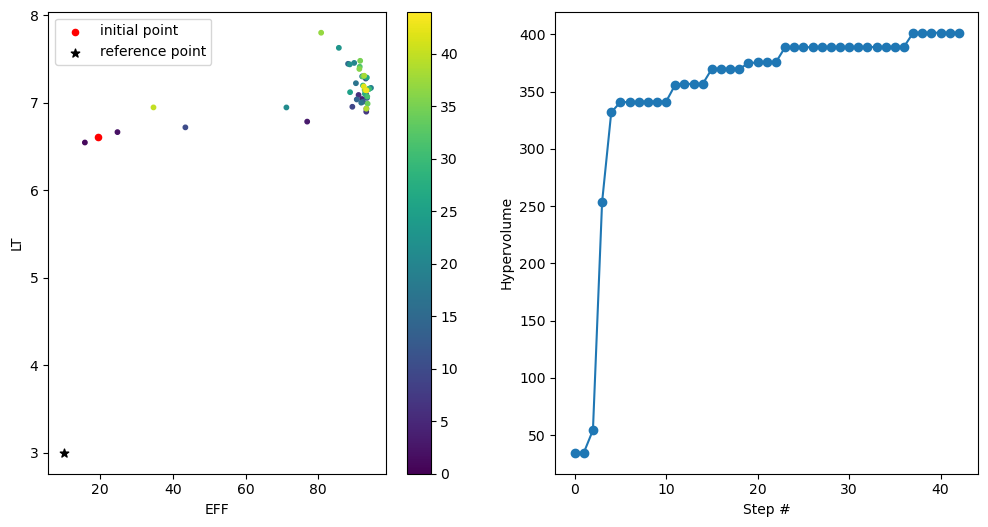

In [17]:
import matplotlib.pyplot as plt

hvs = []
for i in range(1,len(opt.data)):
    hv = opt.generator.calculate_hypervolume_at(i=i)
    hvs.append(hv)

fig,ax = plt.subplots(1,2,squeeze=False,figsize=(12,6))
df = opt.data
ol = ['EFF', 'LT']
l = ax[0,0].scatter(df.loc[:,ol[0]], df.loc[:,ol[1]],10,marker='o',c=range(len(df)),vmax=len(df))
ax[0,0].scatter(df.loc[:1,ol[0]], df.loc[:1,ol[1]], 20,marker='o',c='red',label='initial point')
ax[0,0].scatter(gen.reference_point[ol[0]], gen.reference_point[ol[1]],40,marker='*',c='black',label='reference point')
ax[0,0].set_xlabel(ol[0])
ax[0,0].set_ylabel(ol[1])
fig.colorbar(l)
ax[0,0].legend()

ax[0,1].plot(hvs,marker='o')
ax[0,1].set_xlabel('Step #')
ax[0,1].set_ylabel('Hypervolume')

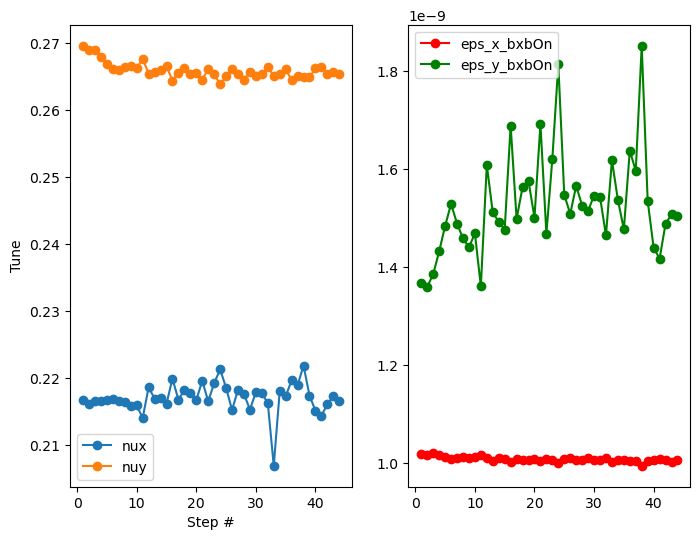

In [18]:
fig,ax = plt.subplots(1,2,squeeze=False,figsize=(8,6))
df = opt.data

ax[0,0].plot(df.loc[:,'_nux'], marker='o', label='nux')
ax[0,0].plot(df.loc[:,'_nuy'], marker='o', label='nuy')
ax[0,1].plot(df.loc[:,'_eps_x_bxbOn'], marker='o', label='eps_x_bxbOn', color='red')
ax[0,1].plot(df.loc[:,'_eps_y_bxbOn']*1e2, marker='o', label='eps_y_bxbOn', color='green')
ax[0,0].set_xlabel('Step #')
ax[0,0].set_ylabel('Tune')
ax[0,0].legend()
ax[0,1].legend()

In [19]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')

In [20]:
# Nominal (i.e., design) sextupole settings:
opt.generate_at({k:0.0 for k in variables.keys()})
opt.evaluate_data()

[INFO ][21:21:15.918 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:21:15.920 evaluators  193] Data kwargs: row={'SH1N': 0.0, 'SH3N': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': 0.0, 'SL3': 0.0, 'SH1-DW08': 0.0, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH3-DW08': 0.0, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH4-DW08': 0.0, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0}
[INFO ][21:21:15.924 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.9665824200000004, 'SH3N': -1.171021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 7.135584290000001, 'SL3': -5.892172122000001, 'SH1-DW08': 3.9665824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.171021682, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.164180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + +0.000 -> +3.967
SH3N   : -1.171 + +0.000 -> -1.171
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + +0.000 -> +7.136
SL3    : -5.892 + +0.000 -> -5.892
SH1-DW08: +3.967 + +0.000 -> +3.967
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.000 -> -1.171
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.000 -> -3.164
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 4.1.
Max FCOR I [A] = 0.078; RMS(dx, dy) [m] = (4.508e-06, 1.068e-06)
Orbit correction converged


[INFO ][21:21:24.093 opt_funcs.  734] Lifetime measurement START
[INFO ][21:21:30.055 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 5 (out of 180)
Lifetime = 7.384 (raw tau [hr] = 8.230, epsy [pm] = 15.32) (took 6.0 [s])
Inj. Eff. = 75.12 (took 19.2 [s])
Eval. func. finished.


[DEBUG][21:21:49.297 evaluators  211] Result: output={'result': {'_nux': 0.21810778738070247, '_nuy': 0.26562337188499646, '_eps_x_bxbOn': 1.0058460139799173e-09, '_eps_y_bxbOn': 1.540246840152814e-11, '_eps_x_bxbOff': 1.005140056118114e-09, '_eps_y_bxbOff': 1.5324147675140342e-11, 'LT': 7.383648482431886, '_raw_LT': 8.230368941999403, 'EFF': 75.11915949587055}, 'exception': None, 'traceback': '', 'wall_time': 33.37616198975593, 'cpu_time': 12.479470227997808}
[DEBUG][21:21:49.299 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:21:49.365 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00043.json] in [0.05345]s


In [25]:
# Spoiled sextupole settings:
opt.generate_at(opt.data.loc[1, opt.gvocs.variable_names].to_dict())
opt.evaluate_data()

[INFO ][21:26:34.226 optimizer.  573] Evaluating 1 inputs
[DEBUG][21:26:34.228 evaluators  193] Data kwargs: row={'SH1-DW08': 0.02, 'SH1-DW18': 0.0, 'SH1-DW28': 0.0, 'SH1N': -0.08, 'SH3-DW08': 0.02, 'SH3-DW18': 0.0, 'SH3-DW28': 0.0, 'SH3N': -0.04, 'SH4-DW08': 0.02, 'SH4-DW18': 0.0, 'SH4-DW28': 0.0, 'SH4N': 0.0, 'SL1': 0.0, 'SL2': -0.15, 'SL3': -0.15}
[INFO ][21:26:34.233 opt_funcs.  688] Setting sextupoles to {'SH1N': 3.8865824200000003, 'SH3N': -1.211021682, 'SH4N': -3.164180142, 'SL1': -2.6543212100000004, 'SL2': 6.98558429, 'SL3': -6.042172122000001, 'SH1-DW08': 3.9865824200000004, 'SH1-DW18': 3.9665824200000004, 'SH1-DW28': 3.9665824200000004, 'SH3-DW08': -1.1510216819999999, 'SH3-DW18': -1.171021682, 'SH3-DW28': -1.171021682, 'SH4-DW08': -3.144180142, 'SH4-DW18': -3.164180142, 'SH4-DW28': -3.164180142}


SH1N   : +3.967 + -0.080 -> +3.887
SH3N   : -1.171 + -0.040 -> -1.211
SH4N   : -3.164 + +0.000 -> -3.164
SL1    : -2.654 + +0.000 -> -2.654
SL2    : +7.136 + -0.150 -> +6.986
SL3    : -5.892 + -0.150 -> -6.042
SH1-DW08: +3.967 + +0.020 -> +3.987
SH1-DW18: +3.967 + +0.000 -> +3.967
SH1-DW28: +3.967 + +0.000 -> +3.967
SH3-DW08: -1.171 + +0.020 -> -1.151
SH3-DW18: -1.171 + +0.000 -> -1.171
SH3-DW28: -1.171 + +0.000 -> -1.171
SH4-DW08: -3.164 + +0.020 -> -3.144
SH4-DW18: -3.164 + +0.000 -> -3.164
SH4-DW28: -3.164 + +0.000 -> -3.164
Sextupole adj. took 1.1.
Max FCOR I [A] = 0.047; RMS(dx, dy) [m] = (8.123e-07, 1.041e-06)
Orbit correction converged


[INFO ][21:26:39.345 opt_funcs.  734] Lifetime measurement START
[INFO ][21:26:48.800 opt_funcs.  781] Efficiency measurement START


** # of outliers found = 4 (out of 180)
Lifetime = 6.731 (raw tau [hr] = 7.050, epsy [pm] = 13.34) (took 9.5 [s])
Inj. Eff. = 26.62 (took 18.4 [s])
Eval. func. finished.


[DEBUG][21:27:07.198 evaluators  211] Result: output={'result': {'_nux': 0.21505604196606318, '_nuy': 0.26797321091644655, '_eps_x_bxbOn': 1.0148419584349396e-09, '_eps_y_bxbOn': 1.337521199761737e-11, '_eps_x_bxbOff': 1.0129623342189795e-09, '_eps_y_bxbOff': 1.333770002832149e-11, 'LT': 6.73079708533524, '_raw_LT': 7.04984597792278, 'EFF': 26.619076334036667}, 'exception': None, 'traceback': '', 'wall_time': 32.968205080367625, 'cpu_time': 15.534752142000798}
[DEBUG][21:27:07.202 optimizer.  291] Adding (1) new data to internal dataframes
[DEBUG][21:27:07.256 optimizer. 1286] Dumped state to [/nsls2/users/yhidaka/.apsopt/2023_12_16-20_43_24-aps_mobo-5791d0cdb1-cd1bfe2c/dump_auto_00044.json] in [0.04943]s


In [26]:
with pd.option_context('display.max_rows', 500):
    display(opt.data)

,SH1N,SH3N,SH4N,SL1,SL2,SL3,SH1-DW08,SH1-DW18,SH1-DW28,SH3-DW08,...,valid,_nux,_nuy,_eps_x_bxbOn,_eps_y_bxbOn,_eps_x_bxbOff,_eps_y_bxbOff,LT,_raw_LT,EFF
1,-0.080000,-0.040000,0.000000,0.000000,-0.150000,-0.150000,0.020000,0.000000,0.000000,0.020000,...,True,0.216735,0.269530,1.019297e-09,1.368940e-11,1.019781e-09,1.364070e-11,6.605279,6.572529,19.603292
2,-0.093752,-0.044161,-0.005859,-0.008500,-0.136579,-0.170182,0.019328,0.008325,-0.009056,0.013636,...,True,0.216185,0.268919,1.016512e-09,1.360334e-11,1.021224e-09,1.349613e-11,6.547267,6.490168,15.867714
3,-0.078793,-0.038338,0.007994,0.012938,-0.184029,-0.122723,0.029271,-0.020818,0.017232,0.020193,...,True,0.216582,0.268858,1.020342e-09,1.385940e-11,1.018632e-09,1.367386e-11,6.666145,6.656249,24.820357
4,-0.057594,-0.028334,0.037755,0.059859,-0.295947,-0.020903,0.055862,-0.089463,0.076796,0.029004,...,True,0.216582,0.267882,1.016547e-09,1.432284e-11,1.015439e-09,1.415206e-11,6.786258,6.904881,76.943604
5,-0.026614,-0.015775,0.069380,0.109093,-0.407451,0.087428,0.080111,-0.157953,0.137785,0.042456,...,True,0.216673,0.266783,1.013193e-09,1.484127e-11,1.012245e-09,1.477197e-11,7.044652,7.336016,92.027393
6,-0.102486,-0.020485,0.061747,0.124510,-0.274407,0.155579,0.094522,-0.058566,0.115423,0.015303,...,True,0.216857,0.266112,1.009757e-09,1.529372e-11,1.012659e-09,1.512148e-11,7.100868,7.490672,93.094683
7,-0.012641,-0.024092,0.063461,0.091602,-0.398252,0.133110,0.082500,-0.212075,0.068066,0.032834,...,True,0.216612,0.265929,1.010012e-09,1.489281e-11,1.010181e-09,1.479225e-11,7.090583,7.404139,91.066677
8,-0.042773,-0.021516,0.071944,0.035020,-0.372886,0.103034,0.091767,-0.104194,0.103655,0.033097,...,True,0.216490,0.266417,1.013580e-09,1.459042e-11,1.012710e-09,1.444198e-11,6.899750,7.125652,93.173208
9,-0.026105,-0.030175,0.063257,0.186416,-0.392119,0.045827,0.085937,-0.104938,0.043533,0.031241,...,True,0.215788,0.266539,1.011206e-09,1.440778e-11,1.013171e-09,1.432780e-11,6.934399,7.140818,93.219382
10,-0.016714,-0.034577,0.060570,0.100430,-0.537494,0.207025,0.090290,-0.039720,0.053253,0.028623,...,True,0.215941,0.266173,1.012066e-09,1.469098e-11,1.011750e-09,1.442825e-11,6.955891,7.198980,89.356535


In [27]:
opt.generator.model.state_dict()

OrderedDict([('models.0.likelihood.noise_covar.raw_noise',
              tensor([0.0020], dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.noise_prior.concentration',
              tensor(1.1000, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.noise_prior.rate',
              tensor(0.0500, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04, dtype=torch.float64)),
             ('models.0.likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf, dtype=torch.float64)),
             ('models.0.mean_module.raw_constant',
              tensor(-1.5098, dtype=torch.float64)),
             ('models.0.covar_module.raw_outputscale',
              tensor(0.7372, dtype=torch.float64)),
             ('models.0.covar_module.base_kernel.raw_lengthscale',
              tensor([[-0.5410, -0.4065, -1.6917, -1.2249, -1.1949, -0.5030, -0.3863, -0.6395,


In [28]:
# This will save optimizer state
if not TEST_MODE:
    opt.state_to_json(f'{datetime.now():%Y%m%dT%H%M%S}_{NAME_ROOT}_dump.json')